## Load Raw Data

This Notebook only retrieves Active Energy data logs

Instances: 10200 - 14700 inclusive (residential units)
Instance : 15100,15300 (Calculation meters; site check, site consumption) 
Instance : 10000,15200 (Check meter; C;G)
Instance : 10100 (House --> assume common area)
Instance : 14900, 15000 (PV: C,G)

In [1]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")


In [2]:
### TODO: Clear below inputs before uploading to Github
Host_ID =  ''  #Insert Host ID as string
StartDate = '01/01/2020'
EndDate = '31/12/2020'
url = 'https:xml' #Insert URL for site

In [3]:
%%time
## Get Raw Data
### Merge into single dataframe, only obtain df and not raw_df 
# TODO: Choosing Range or Batch function to run only once 
%run -i "g_Data.py"

Please enter API_KEY:

········
API_KEY environment variable has been set.
Choose between RANGE or BATCH of meters : RANGE
Enter Starting meter: 10000
Enter Ending meter: 15300
Choose between RANGE or BATCH of meters : RANGE
Enter Starting meter: 10000
Enter Ending meter: 15300
Instance 10000 has been loaded
Instance 10100 has been loaded
Instance 10200 has been loaded
Instance 10300 not available
Instance 10400 not available
Instance 10500 has been loaded
Instance 10600 has been loaded
Instance 10700 has been loaded
Instance 10800 has been loaded
Instance 10900 has been loaded
Instance 11000 has been loaded
Instance 11100 has been loaded
Instance 11200 has been loaded
Instance 11300 has been loaded
Instance 11400 has been loaded
Instance 11500 has been loaded
Instance 11600 has been loaded
Instance 11700 has been loaded
Instance 11800 has been loaded
Instance 11900 has been loaded
Instance 12000 not available
Instance 12100 has been loaded
Instance 12200 has been loaded
Instance 12300

In [4]:
# print(df_trend.info())
print(df_energy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1712775 entries, 0 to 1712774
Data columns (total 3 columns):
 #   Column            Dtype  
---  ------            -----  
 0   time              object 
 1   meter             int64  
 2   ActiveEnergy_log  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 39.2+ MB
None


Order df DataFrame 

In [5]:
#Ordering Categories 
cat = ["January","February","March","April","May","June","July","August","September","October","November","December"]
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert 'time' into timestamps
def sort_df(raw_df):
    raw_df['time'] = pd.to_datetime(raw_df['time'])
    raw_df['month'] = raw_df['time'].dt.strftime('%B')
    raw_df['month'] = pd.Categorical(raw_df['month'],categories = cat, ordered = True)
    raw_df['week'] = raw_df['time'].dt.strftime('%W')  # Monday as start of week
    raw_df['week'] =raw_df['week'].astype('int64')
    raw_df['day'] = raw_df['time'].dt.strftime('%A')
    raw_df['day'] =  pd.Categorical(raw_df['day'],categories = cats, ordered = True)
    raw_df['hour'] = raw_df['time'].dt.hour
    time_interval =raw_df['time'].max()-raw_df['time'].min()
    print("start:",raw_df['time'].min(), "\nend:",raw_df['time'].max(), "\nduration:", time_interval)

    return raw_df

In [6]:
sort_df(df_energy)

### Define peak period equivalent to assumption model 
df_energy.loc[((df_energy['hour'] <= 21) & (df_energy['hour'] >= 8) & (df_energy['day']!='Saturday')& (df_energy['day']!='Sunday')),'Peak_period'] = 'Peak'
df_energy["Peak_period"] = df_energy["Peak_period"].fillna('Off-Peak')
df_energy = df_energy[["meter","time","month","week","hour","Peak_period","ActiveEnergy_log"]]


start: 2020-01-01 00:00:00 
end: 2020-12-31 23:00:00 
duration: 365 days 23:00:00


In [7]:
df_energy

meter                time     month  week  hour Peak_period  \
0        10000 2020-01-31 08:30:00   January     4     8        Peak   
1        10000 2020-01-31 08:45:00   January     4     8        Peak   
2        10000 2020-01-31 09:00:00   January     4     9        Peak   
3        10000 2020-01-31 09:15:00   January     4     9        Peak   
4        10000 2020-01-31 09:30:00   January     4     9        Peak   
...        ...                 ...       ...   ...   ...         ...   
1712770  15300 2020-12-31 22:00:00  December    52    22    Off-Peak   
1712771  15300 2020-12-31 22:15:00  December    52    22    Off-Peak   
1712772  15300 2020-12-31 22:30:00  December    52    22    Off-Peak   
1712773  15300 2020-12-31 22:45:00  December    52    22    Off-Peak   
1712774  15300 2020-12-31 23:00:00  December    52    23    Off-Peak   

         ActiveEnergy_log  
0                 510.000  
1                   0.000  
2                   0.000  
3                   0.000  
4                   0.000  
...                   ...  
1712770             5.030  
1712771             5.384  
1712772             5.867  
1712773             6.102  
1712774             5.657  

[1712775 rows x 7 columns]

Create Dataframes at different sampling rates

In [8]:
### Energy Consumption dataframe
EnergyConsumption_df = df_energy
EnergyConsumption_df["time_hourly"] = EnergyConsumption_df["time"].dt.to_period("H")
EnergyConsumption_df["time_day"] = EnergyConsumption_df["time"].dt.to_period("D")
EnergyConsumption_df['time_month'] = EnergyConsumption_df['time'].dt.to_period('M')

### Monthly Timestamps
E_monthly = EnergyConsumption_df.groupby(['meter','time_month'])['ActiveEnergy_log'].sum().reset_index()
E_monthly['month'] = E_monthly['time_month'].dt.strftime('%B')
E_monthly['month'] = pd.Categorical(E_monthly['month'],categories = cat, ordered = True)

### Daily Timestamps
E_daily = EnergyConsumption_df.groupby(['meter','time_day'])['ActiveEnergy_log'].sum().reset_index()
E_daily['month'] = E_daily['time_day'].dt.strftime('%B')
E_daily['month'] = pd.Categorical(E_daily['month'],categories = cat, ordered = True)
E_daily['day'] = E_daily['time_day'].dt.strftime('%A')
E_daily['day'] =  pd.Categorical(E_daily['day'],categories = cats, ordered = True)
E_daily['week'] = E_daily['time_day'].dt.strftime('%W')  # Monday as start of week
E_daily['week'] = E_daily['week'].astype('int64')

### Hourly Timestamps
EnergyConsumption_df = EnergyConsumption_df.groupby(["meter",'time_hourly'])['ActiveEnergy_log'].sum().reset_index()

EnergyConsumption_df['month'] = EnergyConsumption_df['time_hourly'].dt.strftime('%B')
EnergyConsumption_df['month'] = pd.Categorical(EnergyConsumption_df['month'],categories = cat, ordered = True)
EnergyConsumption_df['week'] = EnergyConsumption_df['time_hourly'].dt.strftime('%W')  # Monday as start of week
EnergyConsumption_df['week'] = EnergyConsumption_df['week'].astype('int64')
EnergyConsumption_df['day'] = EnergyConsumption_df['time_hourly'].dt.strftime('%A')
EnergyConsumption_df['day'] =  pd.Categorical(EnergyConsumption_df['day'],categories = cats, ordered = True)
EnergyConsumption_df['hour'] = EnergyConsumption_df['time_hourly'].dt.hour
EnergyConsumption_df.loc[((EnergyConsumption_df['hour'] <= 21) & (EnergyConsumption_df['hour'] >= 8) & (EnergyConsumption_df['day']!='Saturday')& (EnergyConsumption_df['day']!='Sunday')),'Peak_period'] = 'Peak'
EnergyConsumption_df["Peak_period"] = EnergyConsumption_df["Peak_period"].fillna('Off-Peak')


EnergyConsumption_df = EnergyConsumption_df[['meter','time_hourly','month','week','day','hour','Peak_period','ActiveEnergy_log']]
E_monthly = E_monthly[['meter','time_month','month','ActiveEnergy_log']]
E_daily = E_daily[['meter','time_day','month','week','day','ActiveEnergy_log']]


In [9]:
EnergyConsumption_df

meter       time_hourly     month  week       day  hour Peak_period  \
0       10000  2020-01-31 08:00   January     4    Friday     8        Peak   
1       10000  2020-01-31 09:00   January     4    Friday     9        Peak   
2       10000  2020-01-31 10:00   January     4    Friday    10        Peak   
3       10000  2020-01-31 11:00   January     4    Friday    11        Peak   
4       10000  2020-01-31 12:00   January     4    Friday    12        Peak   
...       ...               ...       ...   ...       ...   ...         ...   
428227  15300  2020-12-31 19:00  December    52  Thursday    19        Peak   
428228  15300  2020-12-31 20:00  December    52  Thursday    20        Peak   
428229  15300  2020-12-31 21:00  December    52  Thursday    21        Peak   
428230  15300  2020-12-31 22:00  December    52  Thursday    22    Off-Peak   
428231  15300  2020-12-31 23:00  December    52  Thursday    23    Off-Peak   

        ActiveEnergy_log  
0                510.000  
1                  0.000  
2                200.000  
3                  0.000  
4                  0.000  
...                  ...  
428227            32.648  
428228            28.029  
428229            21.776  
428230            22.383  
428231             5.657  

[428232 rows x 8 columns]

Slice df for individual instances

In [10]:
### Hourly Data
def meter(instance):
    m_i = EnergyConsumption_df[EnergyConsumption_df["meter"]==instance]
    m_i = m_i.set_index('time_hourly')
    
    return m_i

In [11]:
### Data - 15 minute intervals
def df_energy_m(meter):
    m_i = df_energy[df_energy["meter"]==meter]
    m_i = m_i[["time","month","week","hour","ActiveEnergy_log"]]
    return m_i

In [12]:
### Set Main site meters based on 15 min Intervals
Meter_C_15 = df_energy_m(10000)
Meter_G_15 = df_energy_m(15200)
PV_G_15 = df_energy_m(15000)
Site_consumption_15= df_energy_m(15100)

In [13]:
### Setting non-residential unit meters

PV_C = meter(14900)              ### (ignored)
PV_G = meter(15000)              ### Total PV Generation of site
Meter_C = meter(10000)           ### Net import from network to site
Meter_G = meter(15200)           ### Net PV Export from site to the network
Site_consumption = meter(15100)  ### Total Site consumption
Site_meter = meter(15300)        ### Site Check Meter
House = meter(10100)             ### Consumption of Common Area

### Residential Unit meters (15 minute interval)
Residential = df_energy.iloc[67352:1542938]

### Total Site Consumption (residential + common area)
# residential["ActiveEnergy_log"].sum() + house["ActiveEnergy_log"].sum()

#### Total Building Summary

In [14]:
def negative_clean_up(value):
    """Converts all negative values to positive and 0 for else"""
    if value<0:
        return(abs(value))
    else:
        return(0)     

In [15]:
### Load profile B 
### Totals Based off "SEC EN Proj Ass RevH_ Yaran St56.xlsm"
building_energy_consumption = 231251.20
PV_production = 69350
off_peak_import= 98200.22763
peak_import = 80398.36374
export = 16697.39631
export_production_percent = (export/PV_production)*100

### Load Profile A (higher common load profile)
### Totals Based off "SEC EN Proj Ass RevH_ Yaran St56.xlsm"
# building_energy_consumption = 263360.59
# PV_production = 69350
# off_peak_import= 105162.1846
# peak_import = 89035.26259
# export = 186.8619101
# export_production_percent = (export/PV_production)*100

In [18]:
### Total Site data
site_total = meter(15100)
site_total["PV_G"] = PV_G["ActiveEnergy_log"]/1000
site_total["Export"] = Meter_G["ActiveEnergy_log"]/1000
site_total["Network_consumption"] = Meter_C["ActiveEnergy_log"]/1000
site_total["Grid_Load"] = site_total["ActiveEnergy_log"] - site_total["PV_G"]
site_total

meter     month  week        day  hour Peak_period  \
time_hourly                                                            
2020-01-01 00:00  15100   January     0  Wednesday     0    Off-Peak   
2020-01-01 01:00  15100   January     0  Wednesday     1    Off-Peak   
2020-01-01 02:00  15100   January     0  Wednesday     2    Off-Peak   
2020-01-01 03:00  15100   January     0  Wednesday     3    Off-Peak   
2020-01-01 04:00  15100   January     0  Wednesday     4    Off-Peak   
...                 ...       ...   ...        ...   ...         ...   
2020-12-31 19:00  15100  December    52   Thursday    19        Peak   
2020-12-31 20:00  15100  December    52   Thursday    20        Peak   
2020-12-31 21:00  15100  December    52   Thursday    21        Peak   
2020-12-31 22:00  15100  December    52   Thursday    22    Off-Peak   
2020-12-31 23:00  15100  December    52   Thursday    23    Off-Peak   

                  ActiveEnergy_log   PV_G  Export  Network_consumption  \
time_hourly                                                              
2020-01-01 00:00             6.356  0.000     NaN                  NaN   
2020-01-01 01:00             9.198  0.000     NaN                  NaN   
2020-01-01 02:00             7.570  0.000     NaN                  NaN   
2020-01-01 03:00             9.051  0.000     NaN                  NaN   
2020-01-01 04:00             6.250  0.000     NaN                  NaN   
...                            ...    ...     ...                  ...   
2020-12-31 19:00            33.351  0.703     0.0                32.82   
2020-12-31 20:00            28.029  0.000     0.0                28.26   
2020-12-31 21:00            21.776  0.000     0.0                21.86   
2020-12-31 22:00            22.383  0.000     0.0                22.42   
2020-12-31 23:00             5.657  0.000     0.0                 5.64   

                  Grid_Load  
time_hourly                  
2020-01-01 00:00      6.356  
2020-01-01 01:00      9.198  
2020-01-01 02:00      7.570  
2020-01-01 03:00      9.051  
2020-01-01 04:00      6.250  
...                     ...  
2020-12-31 19:00     32.648  
2020-12-31 20:00     28.029  
2020-12-31 21:00     21.776  
2020-12-31 22:00     22.383  
2020-12-31 23:00      5.657  

[8784 rows x 11 columns]

In [19]:
### Total Building Consumption
Building_consumption = site_total["ActiveEnergy_log"].sum()

### Total PV Generation
# Total_PV_generation = Site["PV_G"].sum()
Total_PV_generation = site_total["PV_G"].sum()

### Total PV Exported
# Total_PV_exported = abs(Site.query("Grid_load <0")["Grid_load"]).sum()
Total_PV_exported = site_total["Export"].sum()

### Total PV Consumed 
Total_PV_consumed = Total_PV_generation - Total_PV_exported

### Total Import from Grid
Total_import = site_total["Network_consumption"].sum()

### Total Off-Peak import
Total_off_peak_import = site_total.query("Peak_period=='Off-Peak'")["Network_consumption"].sum()

### Total Peak import 
Total_peak_import = site_total.query("Peak_period=='Peak'")["Network_consumption"].sum()

In [20]:
### Load Profile A summary
Loads = pd.DataFrame(columns=["Total","Actual"])
Loads["Total"] = ['Building_consumption','Total_PV_generation','Total_off_peak_import','Total_peak_import','Total_PV_exported','Total_PV_consumed',"Total_Export%_of_production","Solar_PV_production_rate(kWhr/kWp/d)"]
Loads["Actual"] = [Building_consumption,Total_PV_generation,Total_off_peak_import,Total_peak_import,Total_PV_exported,Total_PV_consumed,(Total_PV_exported/Total_PV_generation)*100,site_total["PV_G"].sum()/366/50]
Loads["Estimated"] = [building_energy_consumption,PV_production,off_peak_import,peak_import,export,(PV_production-export),(export/PV_production)*100,4.2304]
Loads["Variation"] = ((Loads["Actual"]-Loads["Estimated"])/Loads["Estimated"])*100
Loads

Total         Actual      Estimated  \
0                  Building_consumption  163946.553000  231251.200000   
1                   Total_PV_generation   99222.159000   69350.000000   
2                 Total_off_peak_import   64959.510000   98200.227630   
3                     Total_peak_import   39686.420000   80398.363740   
4                     Total_PV_exported   38806.900000   16697.396310   
5                     Total_PV_consumed   60415.259000   52652.603690   
6           Total_Export%_of_production      39.111122      24.076995   
7  Solar_PV_production_rate(kWhr/kWp/d)       5.421976       4.230400   

    Variation  
0  -29.104561  
1   43.074490  
2  -33.849939  
3  -50.637776  
4  132.412882  
5   14.743156  
6   62.441873  
7   28.166980

<IPython.core.display.Javascript object>


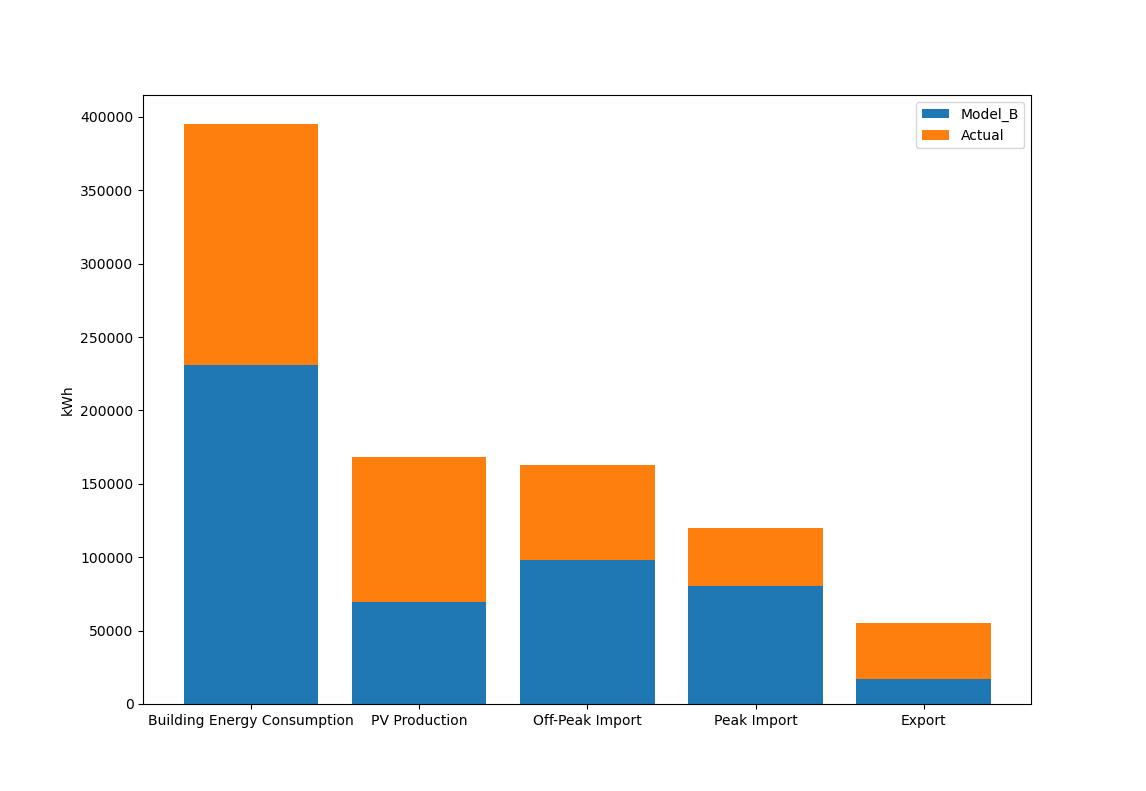

In [21]:
### Total Building Annual Energy Profile (2020) (PROFILE_B)

%matplotlib notebook 

loads = [Building_consumption,Total_PV_generation,Total_off_peak_import,Total_peak_import,Total_PV_exported]
load_model  = [building_energy_consumption,PV_production,off_peak_import,peak_import,export]
x = np.arange(5)

fig, ax = plt.subplots(figsize=(8, 8))
plt.bar(x, load_model,label="Model_B")
plt.xticks(x, ('Building Energy Consumption', 'PV Production', 'Off-Peak Import', 'Peak Import','Export'))
plt.bar(x,loads,label="Actual",bottom = load_model)
plt.ylabel("kWh")
plt.legend()
plt.show()

#### Energy Sales summary

In [22]:
### Energy Sales excluding solar export sales (PROFILE_B)

resi_sales = 0.2484*(Residential["ActiveEnergy_log"].sum()/1000)
comm_sales = 0.2329*(House["ActiveEnergy_log"].sum()/1000)
supply_charges = (42*366*0.91391)  + (0.93*0.2329)
total_revenue = resi_sales + comm_sales + supply_charges

## Excludes set up costs 
ongoing_costs= (42*0.25*366)+(0.01*total_revenue) +1000 + 2500

#need to update as PV generation still unclear 
total_energy_costs = Total_off_peak_import*0.12  + Total_peak_import*0.355 + 3.05*365
CoGs = total_energy_costs + ongoing_costs 
margin = total_revenue - CoGs
strata = 6000
set_up_costs = 78600

annual_margin = margin - strata 
ROI = (annual_margin/set_up_costs)*100


Sales = pd.DataFrame(columns=["Total ($/year)","Actual","Model"])
Sales["Total ($/year)"] = ["Residential_sales","Common_usage_sales","Supply_charges","Revenue","Energy_costs","ongoing_costs","CoGs","Margin","Annual_margin","ROI","SEC_capex","ROI_new"]
Sales["Actual"] = [resi_sales,comm_sales,supply_charges,total_revenue,total_energy_costs,ongoing_costs,CoGs,margin,annual_margin,ROI,57771.00,(annual_margin/57771)*100]
Sales["Model"] = [52761.60,4453.29,13031.11,70246.00,41438.7,8252.46,49691.16,20554.84,14554.84,18.52,57771,25]
Sales["Variation"] = ((Sales["Actual"]-Sales["Model"])/Sales["Model"])*100


Sales

Total ($/year)        Actual     Model  Variation
0    Residential_sales  36665.512726  52761.60 -30.507201
1   Common_usage_sales   3801.615521   4453.29 -14.633551
2       Supply_charges  14048.841117  13031.11   7.810011
3              Revenue  54515.969363  70246.00 -22.392778
4         Energy_costs  22997.070300  41438.70 -44.503398
5        ongoing_costs   7888.159694   8252.46  -4.414445
6                 CoGs  30885.229994  49691.16 -37.845625
7               Margin  23630.739370  20554.84  14.964356
8        Annual_margin  17630.739370  14554.84  21.133172
9                  ROI     22.430966     18.52  21.117528
10           SEC_capex  57771.000000  57771.00   0.000000
11             ROI_new     30.518321     25.00  22.073285

In [23]:
### Cash flow based on PROFILE_B model
cash_flow = pd.DataFrame(columns=["year","annual_margin","accumulative"])
cash_flow["year"]= range(1,13)
cash_flow["annual_margin"] = annual_margin
cash_flow["accumulative"] = cash_flow["annual_margin"].cumsum()
cash_flow["model_margin"] = 20554.84
cash_flow["model_accumulative"] = cash_flow["model_margin"].cumsum()
cash_flow["variation"] = 100*((cash_flow["accumulative"] - cash_flow["model_accumulative"])/cash_flow["model_accumulative"])
cash_flow

year  annual_margin   accumulative  model_margin  model_accumulative  \
0      1    17630.73937   17630.739370      20554.84            20554.84   
1      2    17630.73937   35261.478740      20554.84            41109.68   
2      3    17630.73937   52892.218109      20554.84            61664.52   
3      4    17630.73937   70522.957479      20554.84            82219.36   
4      5    17630.73937   88153.696849      20554.84           102774.20   
5      6    17630.73937  105784.436219      20554.84           123329.04   
6      7    17630.73937  123415.175588      20554.84           143883.88   
7      8    17630.73937  141045.914958      20554.84           164438.72   
8      9    17630.73937  158676.654328      20554.84           184993.56   
9     10    17630.73937  176307.393698      20554.84           205548.40   
10    11    17630.73937  193938.133067      20554.84           226103.24   
11    12    17630.73937  211568.872437      20554.84           246658.08   

    variation  
0   -14.22585  
1   -14.22585  
2   -14.22585  
3   -14.22585  
4   -14.22585  
5   -14.22585  
6   -14.22585  
7   -14.22585  
8   -14.22585  
9   -14.22585  
10  -14.22585  
11  -14.22585

In [28]:
### TOTAL DAILY RESIDENTIAL CONSUMPTION
resi_df = EnergyConsumption_df.iloc[16840:385768]
resi_df = resi_df.groupby(["meter","week","day"])["ActiveEnergy_log"].sum().reset_index()
resi_df = resi_df.iloc[2:15579]
resi_df = resi_df.rename(columns = {"ActiveEnergy_log":"Total_consumption"})
resi_df

meter  week        day  Total_consumption
2      10200     0  Wednesday             1973.0
3      10200     0   Thursday             2378.0
4      10200     0     Friday             2421.0
5      10200     0   Saturday             2314.0
6      10200     0     Sunday             1827.0
...      ...   ...        ...                ...
15574  14700    51     Sunday            22973.0
15575  14700    52     Monday            18472.0
15576  14700    52    Tuesday            11598.0
15577  14700    52  Wednesday             2294.0
15578  14700    52   Thursday             1319.0

[15577 rows x 4 columns]

### Site summary plots 

<IPython.core.display.Javascript object>


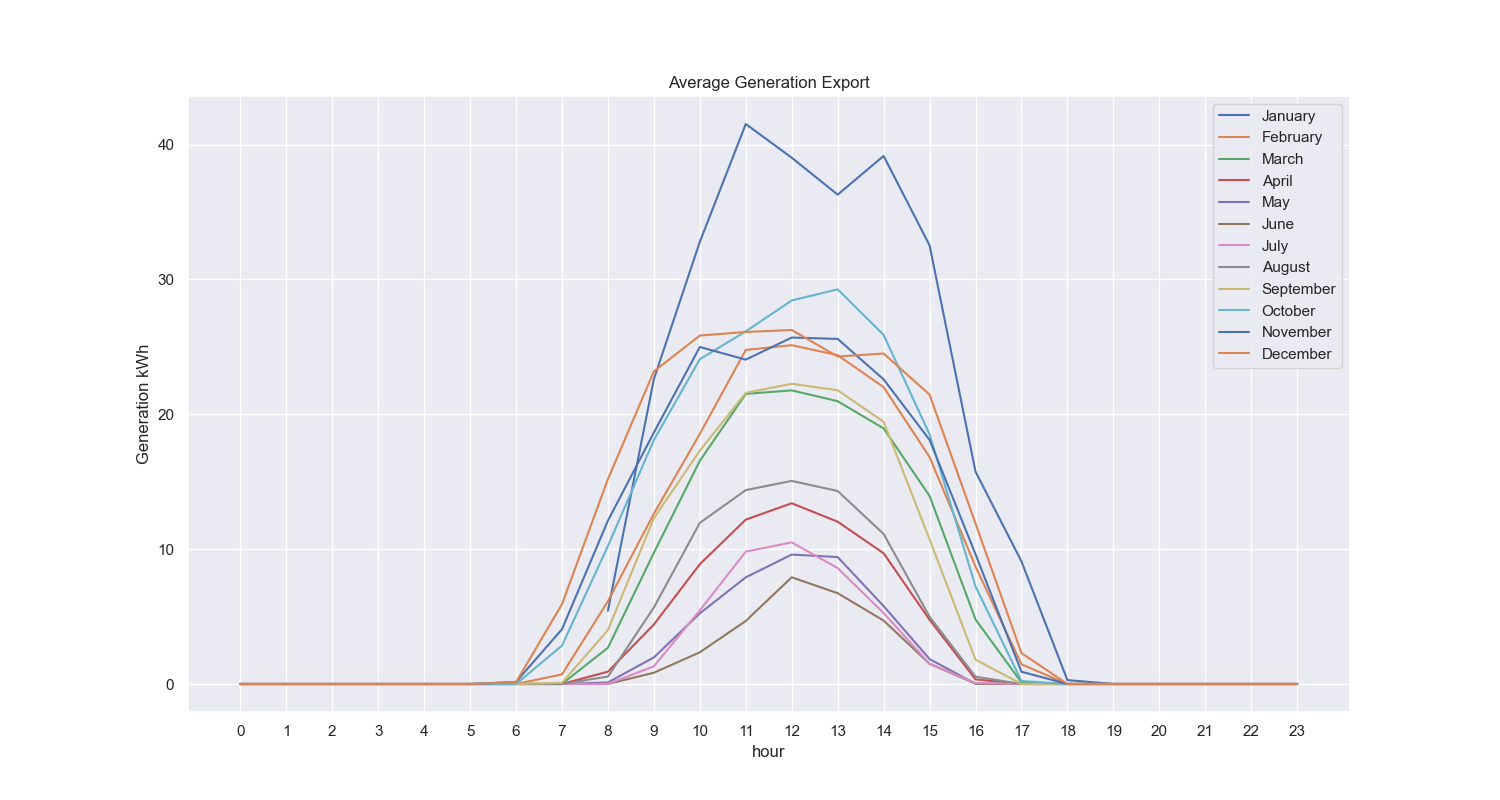

<IPython.core.display.Javascript object>


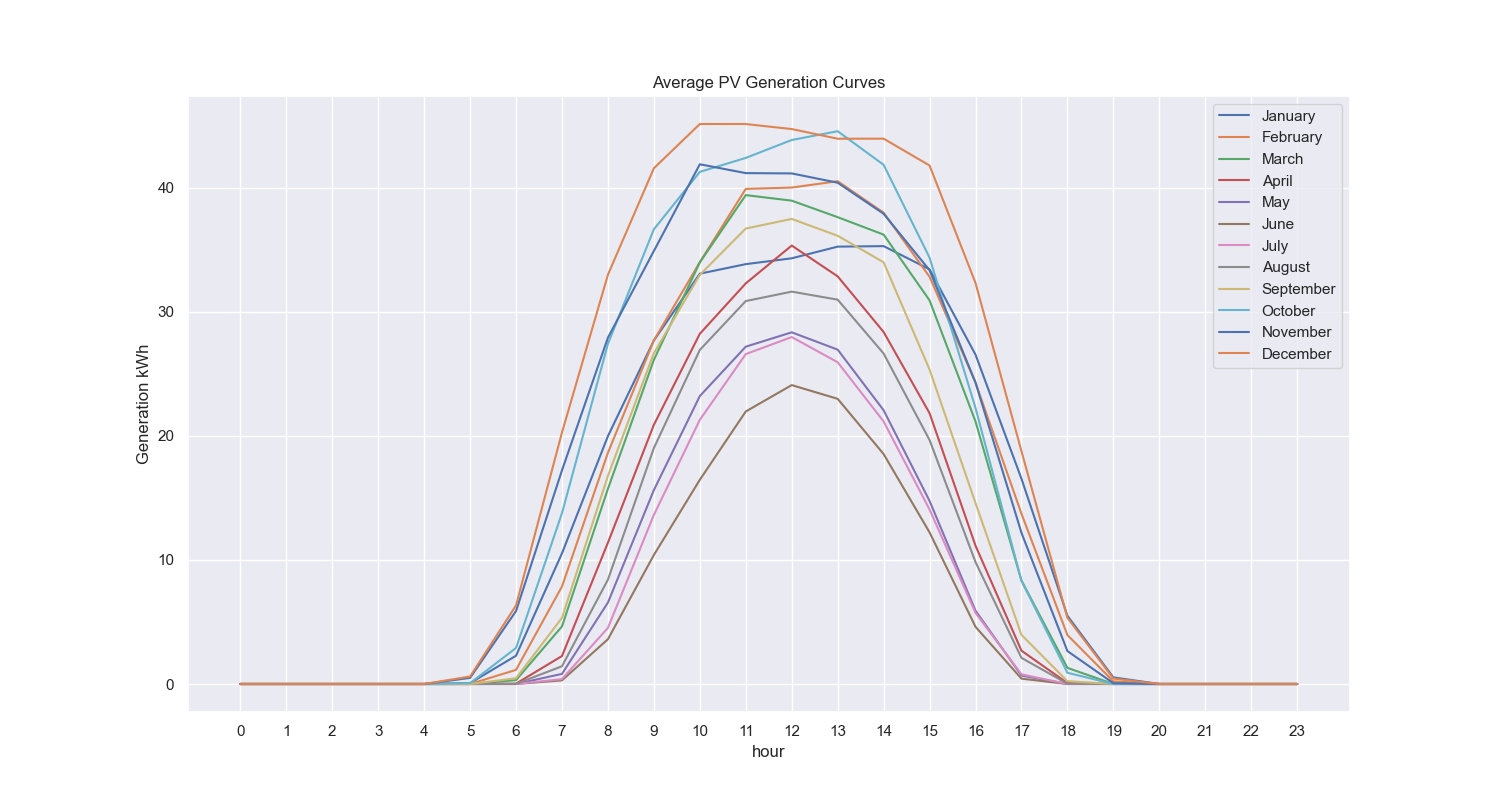

<IPython.core.display.Javascript object>


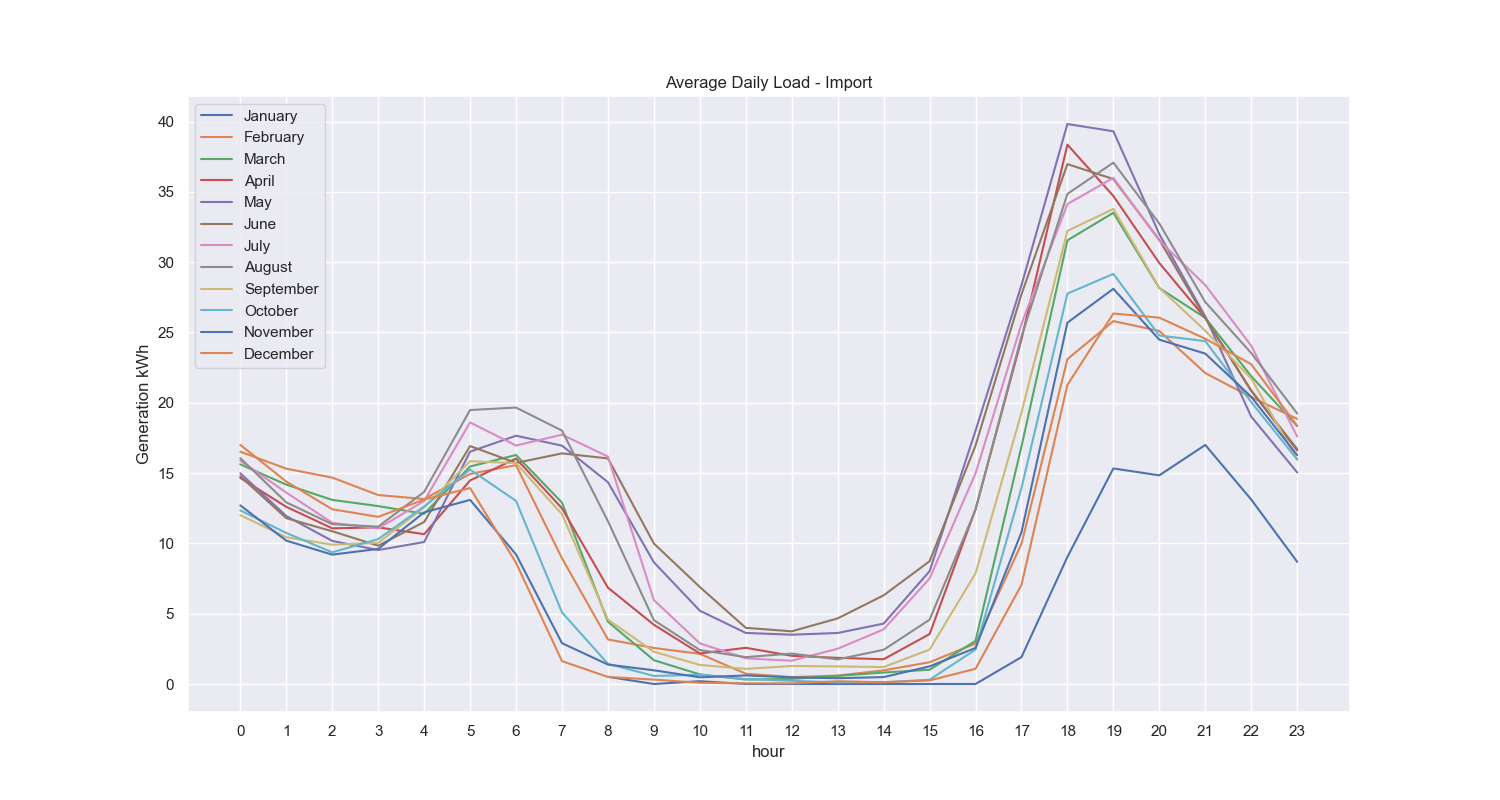

<IPython.core.display.Javascript object>


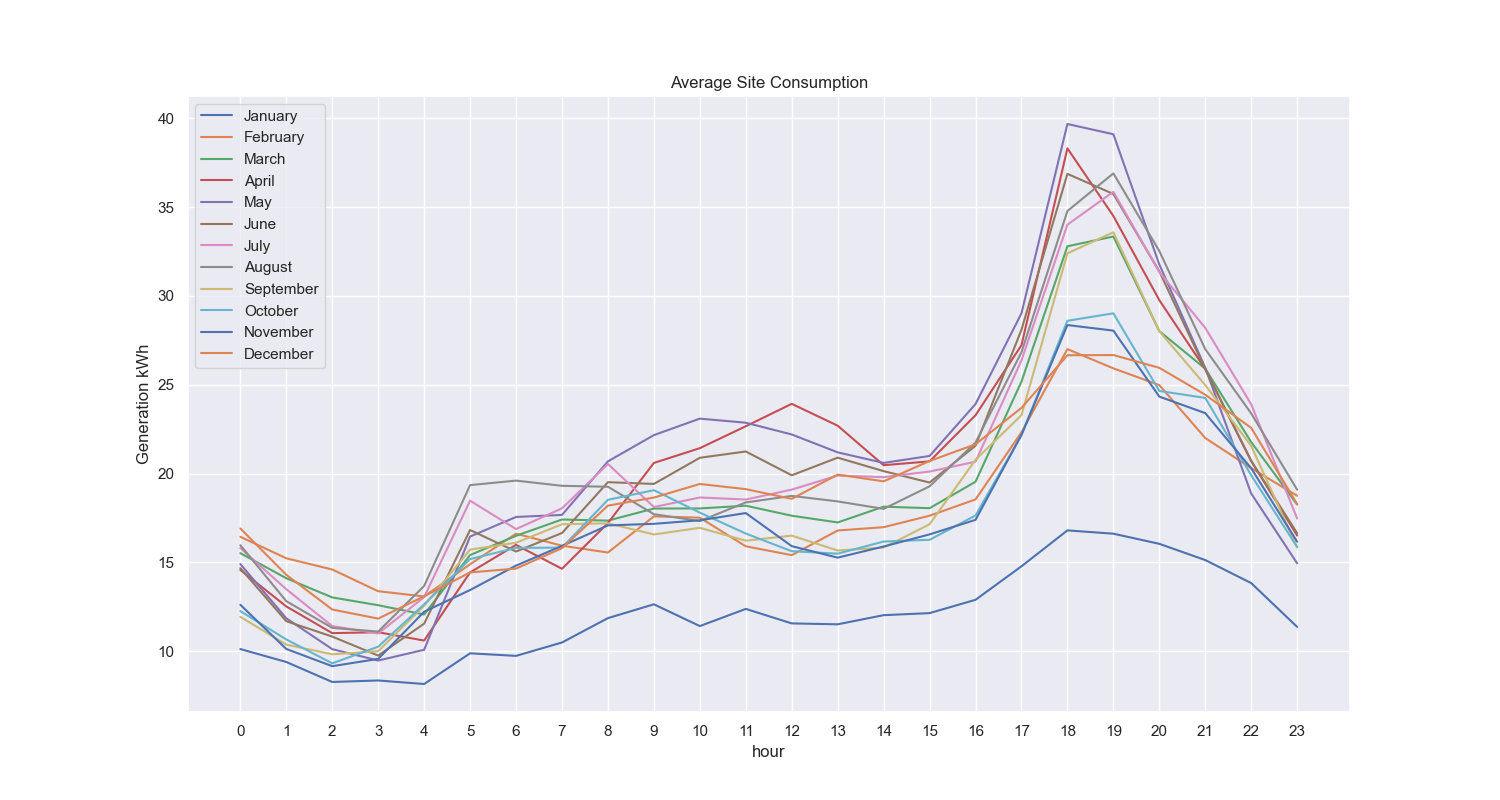

<IPython.core.display.Javascript object>


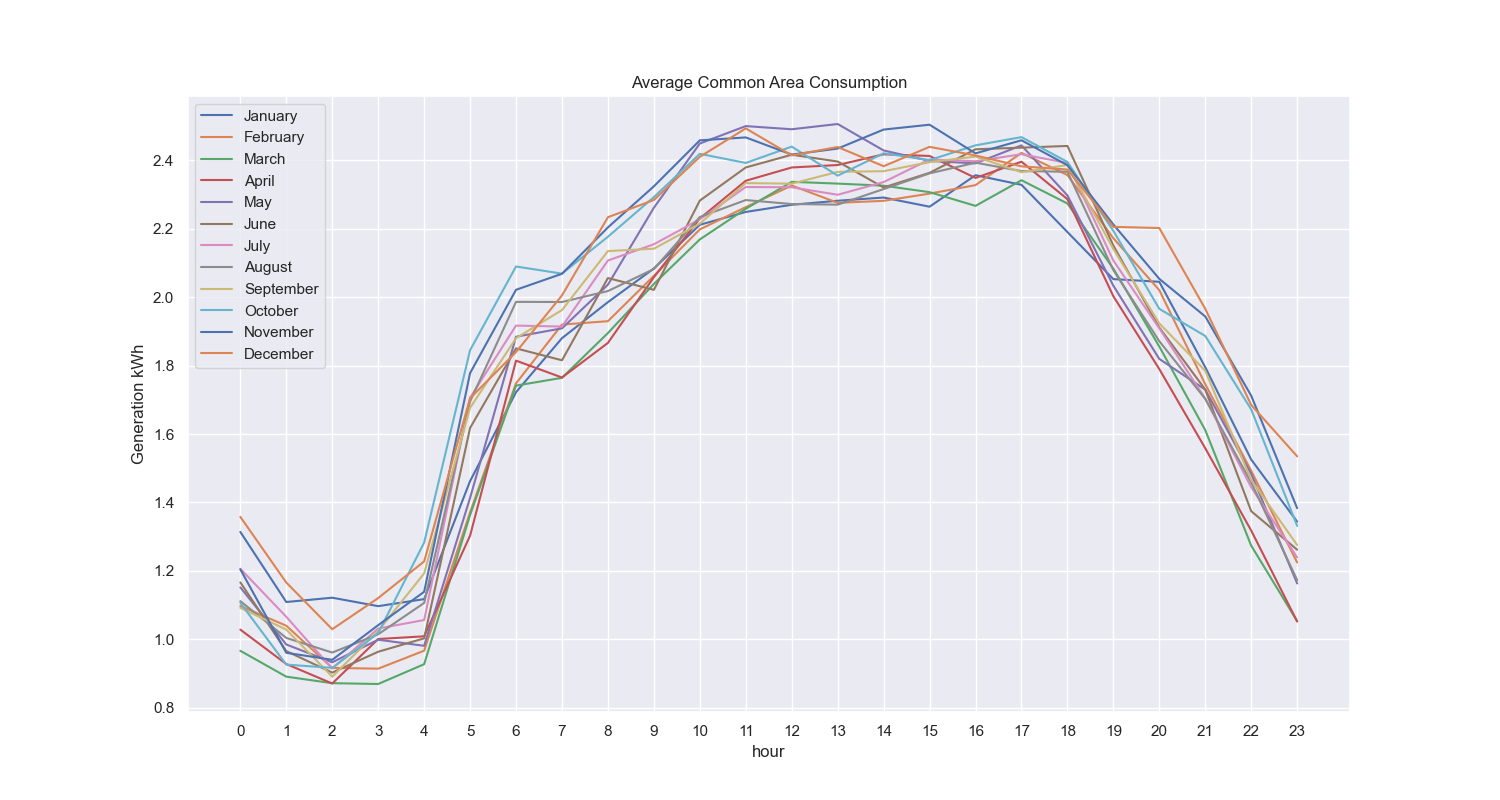

In [28]:
sns.set(style='darkgrid')
daily_solar_export= (Meter_G.groupby(["month","hour"])["ActiveEnergy_log"].mean()/1000).reset_index()
daily_solar_generation=(PV_G.groupby(["month","hour"])["ActiveEnergy_log"].mean()/1000).reset_index()
daily_consumption = Site_consumption.groupby(["month","hour"])["ActiveEnergy_log"].mean().reset_index()
com_area_consumption = (House.groupby(["month","hour"])["ActiveEnergy_log"].mean()/1000).reset_index()
daily_grid_import= (Meter_C.groupby(["month","hour"])["ActiveEnergy_log"].mean()/1000).reset_index()

fig, ax1= plt.subplots(1,1, figsize=(15,8))
fig, ax2= plt.subplots(1,1, figsize=(15,8))
fig, ax3= plt.subplots(1,1, figsize=(15,8))
fig, ax4= plt.subplots(1,1, figsize=(15,8))
fig, ax5= plt.subplots(1,1, figsize=(15,8))

for month in cat:
        daily_solar_export[daily_solar_export["month"]==month].plot(x='hour',y="ActiveEnergy_log",ax=ax1,label=str(month))
        ax1.set(xticks = range(24),xticklabels = range(24),xlabel = 'hour',ylabel = 'Generation kWh',title='Average Generation Export')
        ax1.legend(loc='upper right')   
        
        daily_solar_generation[daily_solar_generation["month"]==month].plot(x='hour',y="ActiveEnergy_log",ax=ax2, label=str(month))
        ax2.set(xticks = range(24),xticklabels = range(24),xlabel = 'hour',ylabel = 'Generation kWh',title='Average PV Generation Curves')
        ax2.legend(loc='upper right')   
        
        daily_grid_import[daily_grid_import["month"]==month].plot(x='hour',y="ActiveEnergy_log",ax=ax3,label=str(month))
        ax3.set(xticks = range(24),xticklabels = range(24),xlabel = 'hour',ylabel = 'Generation kWh',title='Average Daily Load - Import')
        ax3.legend(loc='upper left')   
        
        daily_consumption[daily_consumption["month"]==month].plot(x='hour',y="ActiveEnergy_log",ax=ax4, label=str(month))
        ax4.set(xticks = range(24),xticklabels = range(24),xlabel = 'hour',ylabel = 'Generation kWh',title='Average Site Consumption')
        ax4.legend(loc='upper left')   
        
        com_area_consumption[com_area_consumption["month"]==month].plot(x='hour',y="ActiveEnergy_log",ax=ax5, label=str(month))
        ax5.set(xticks = range(24),xticklabels = range(24),xlabel = 'hour',ylabel = 'Generation kWh',title='Average Common Area Consumption')
        ax5.legend(loc='upper left')   
    

# Profile_A.plot(x="hour",y="PV_profile",ax=ax1,label="model_PV_ave",ls='--')
# Profile_A.plot(x="hour",y="PV_profile",ax=ax2,label="model_PV_ave",ls='--')

<IPython.core.display.Javascript object>


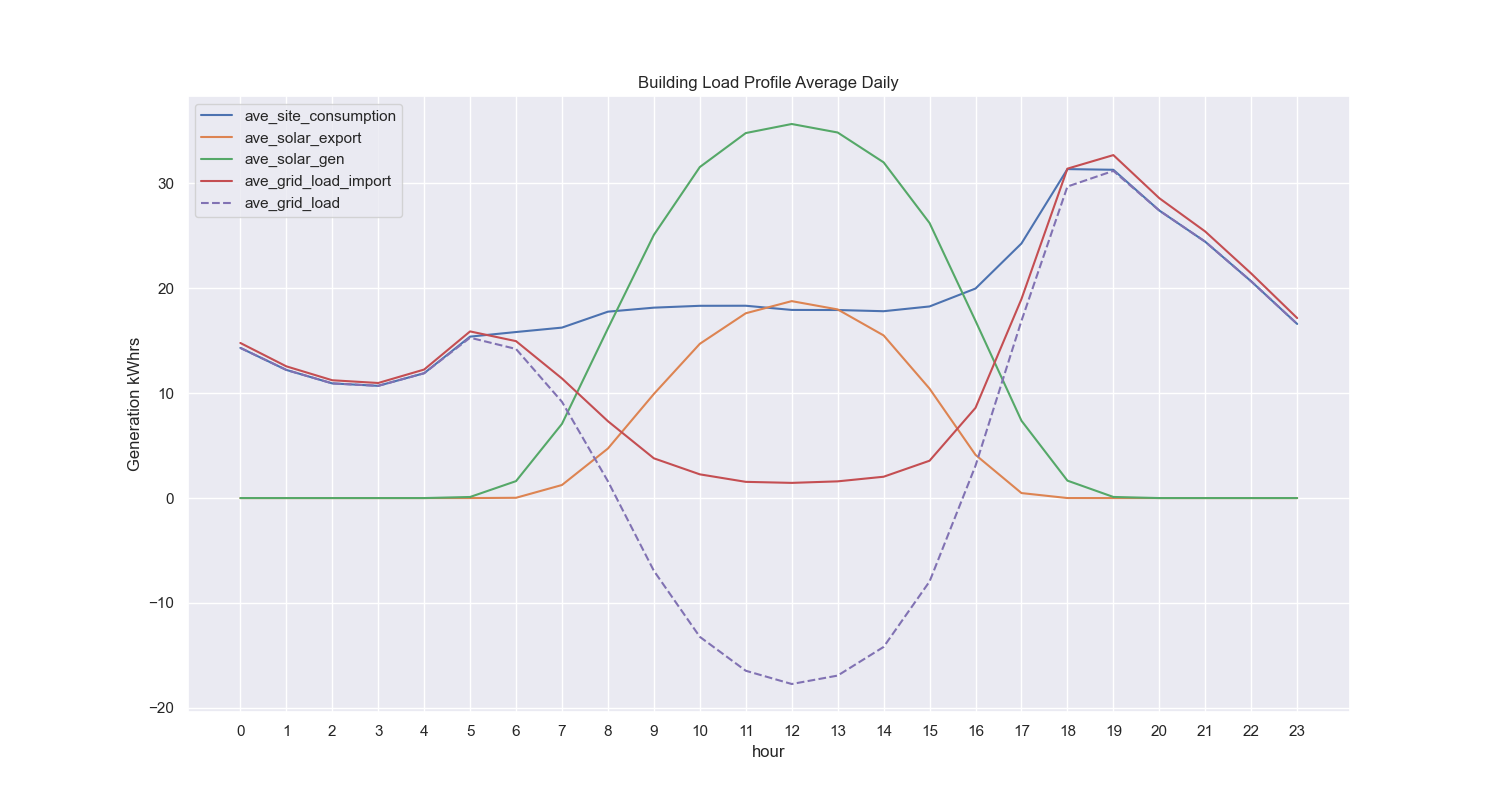

In [31]:
fig, ax= plt.subplots(1,1, figsize=(15,8))

calc_ave_grid_load = site_total.groupby(["hour"])["Grid_Load"].mean().reset_index()
ave_solar_export = (Meter_G.groupby(["hour"])["ActiveEnergy_log"].mean()/1000).reset_index()
ave_solar_gen=(PV_G.groupby(["hour"])["ActiveEnergy_log"].mean()/1000).reset_index()
ave_grid_import = (Meter_C.groupby(["hour"])["ActiveEnergy_log"].mean()/1000).reset_index()
ave_consumption = Site_consumption.groupby(["hour"])["ActiveEnergy_log"].mean().reset_index()
ave_com_area_consumption = (House.groupby(["hour"])["ActiveEnergy_log"].mean()/1000).reset_index()

ave_consumption.plot(x='hour',y="ActiveEnergy_log",ax=ax,label="ave_site_consumption")
ave_solar_export.plot(x='hour',y="ActiveEnergy_log",ax=ax,label="ave_solar_export")
ave_solar_gen.plot(x='hour',y="ActiveEnergy_log",ax=ax,label="ave_solar_gen")
ave_grid_import.plot(x='hour',y="ActiveEnergy_log",ax=ax,label="ave_grid_load_import")
calc_ave_grid_load.plot(x='hour',y="Grid_Load",ax=ax,label="ave_grid_load",ls='--')

# Profile_B.plot(x="hour",y="PV_profile",ax=ax,label="model_PV_ave",ls='-.')


# ave_com_area_consumption.plot(x='hour',y="ActiveEnergy_log",ax=ax,label="ave_com_area_consumption")

ax.set(xticks = range(24),xticklabels = range(24),xlabel = 'hour',ylabel = 'Generation kWhrs',title='Building Load Profile Average Daily')
ax.legend(loc='upper left')   

### Load Profiles

In [21]:
%matplotlib notebook

<IPython.core.display.Javascript object>


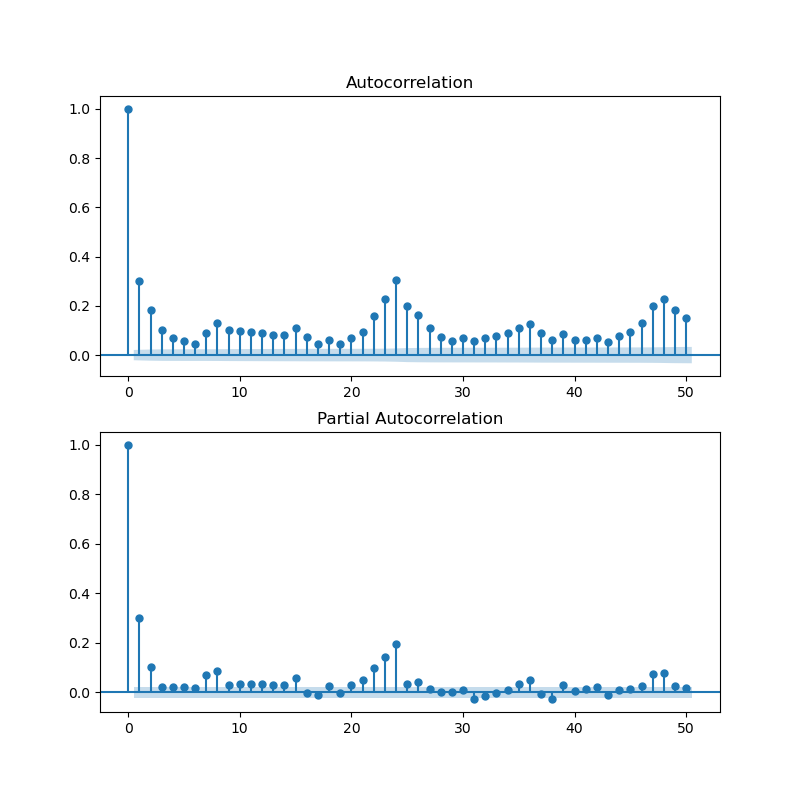

In [25]:
### Autocorrelation and Partial Correlation Function plots
plt.figure(figsize=(8, 8))
lags = 50
# acf
axis = plt.subplot(2, 1, 1)
plot_acf(m_10200["ActiveEnergy_log"], ax=axis, lags=lags)
# pacf
axis = plt.subplot(2, 1, 2)
plot_pacf(m_10200["ActiveEnergy_log"], ax=axis, lags=lags)
# show plot
plt.show()

In [22]:
def display_load(df_energy):
    DF = df_energy[['time','ActiveEnergy_log']]
    DF = DF.set_index('time')
    DF = DF.replace('?',np.nan)
    DF = DF.astype(np.float).fillna(method='bfill')

    DF_H = DF.resample('H').sum()
    DF_H['hour'] = DF_H.index.hour
    DF_H.index = DF_H.index.date

    DF_pivot = DF_H.pivot(columns='hour')
    DF_pivot = DF_pivot.dropna()
    
    return DF_pivot

<IPython.core.display.Javascript object>


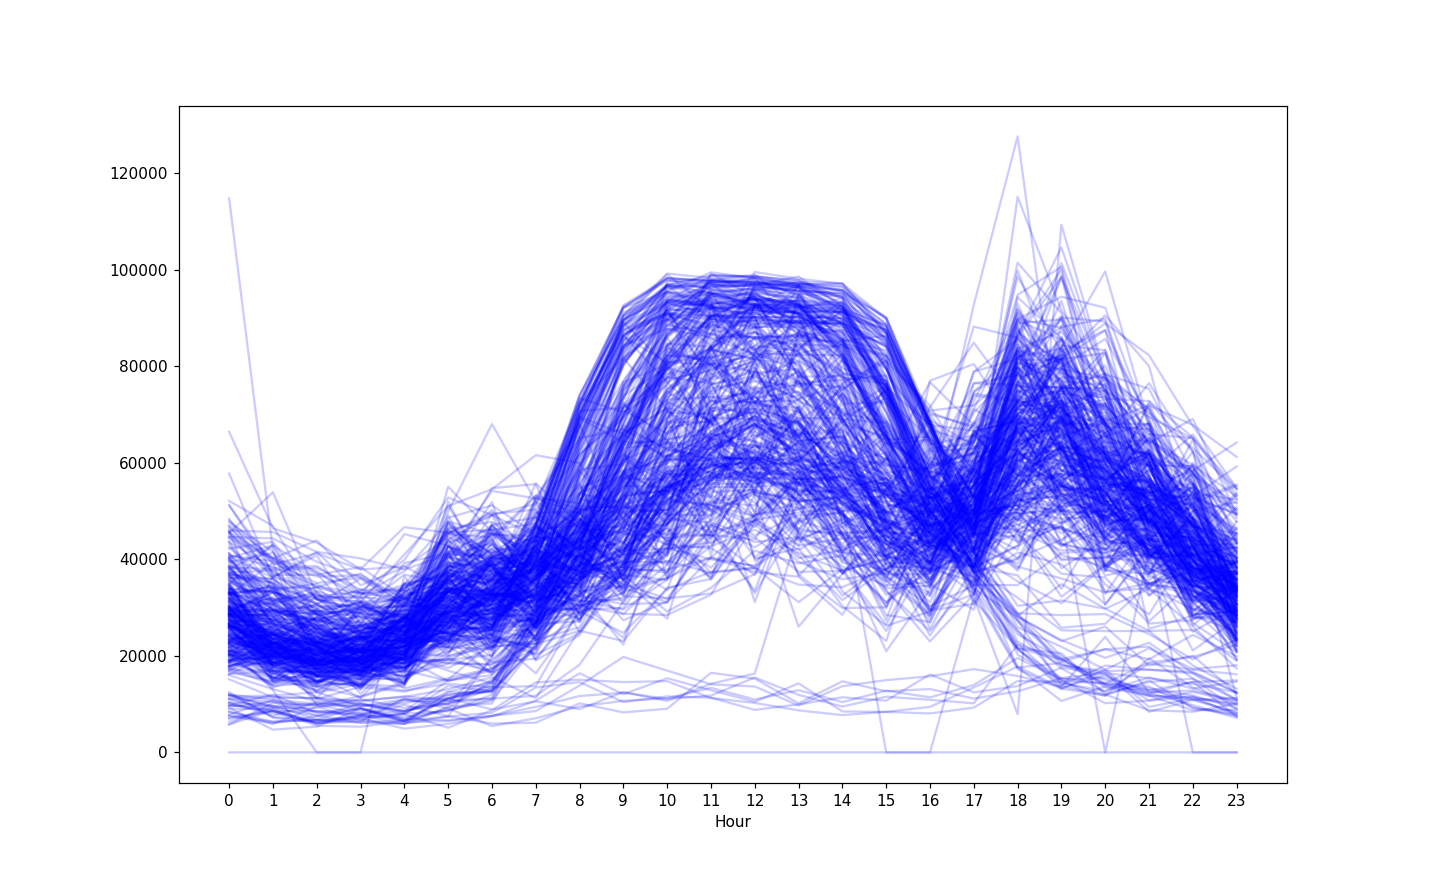

In [23]:
### Display all load profiles for all instances (Does not normalize the load)
DF_pivot = display_load(df_energy)

a = DF_pivot.T.plot(figsize=(13,8), legend=False, color='blue', alpha=0.2)
a.set(xticks = range(0,24),xlabel='Hour', xticklabels = range(0,24))
plt.show()


In [24]:
### Initialise clustering model

DF_pivot = display_load(df_energy)

silhouette_scores = []
n_cluster_list = np.arange(2,31).astype(int)

X = DF_pivot.values.copy()

sc = MinMaxScaler()
X = sc.fit_transform(X)

for n_cluster in n_cluster_list:
    kmeans = KMeans(n_clusters = n_cluster)
    cluster_found = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X,kmeans.labels_))

<IPython.core.display.Javascript object>


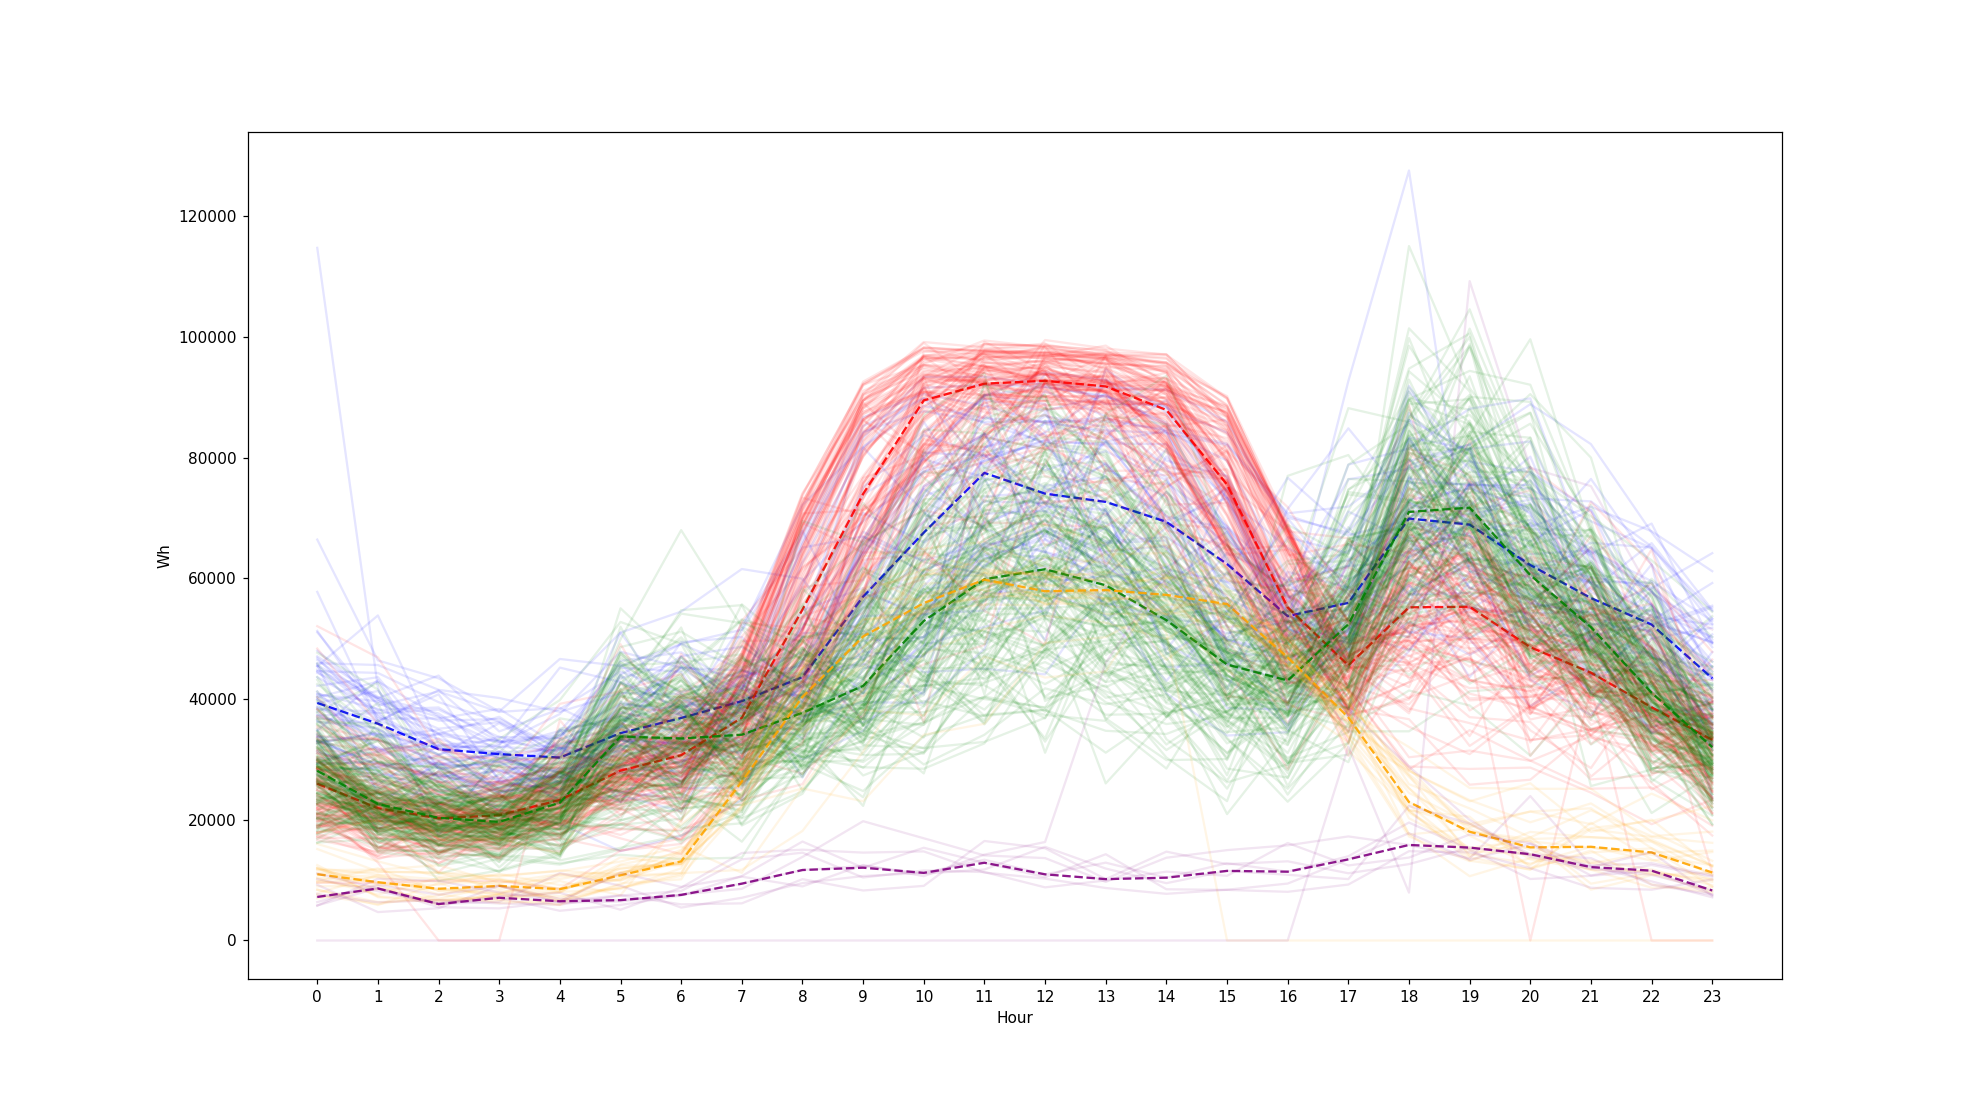

Text(0, 0.5, 'Wh')

In [25]:
### Display main clusters for load profile
## note the load profile clusters may change each time it is run due to the model
kmeans = KMeans(n_clusters=5)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name='cluster')
DF_pivot = DF_pivot.set_index(cluster_found_sr, append=True )

fig, ax= plt.subplots(1,1, figsize=(18,10))
# palette = plt.get_cmap('tab10')
colour_list = ['blue','red','green','orange','purple','brown']
# for num in range(0,6,1):
#     colour_list.append(palette(num))

cluster_values = sorted(DF_pivot.index.get_level_values('cluster').unique())

for cluster,colour in zip(cluster_values,colour_list):
    DF_pivot.xs(cluster, level=1).T.plot(ax=ax, legend=False, alpha=0.1, color=colour, label= f'Cluster {cluster}')
    DF_pivot.xs(cluster, level=1).median().plot(ax=ax, color=colour, alpha=0.9, ls='--')

ax.set(xticks = range(0,24),xlabel='Hour', xticklabels = range(0,24))
ax.set_ylabel('Wh')



<IPython.core.display.Javascript object>


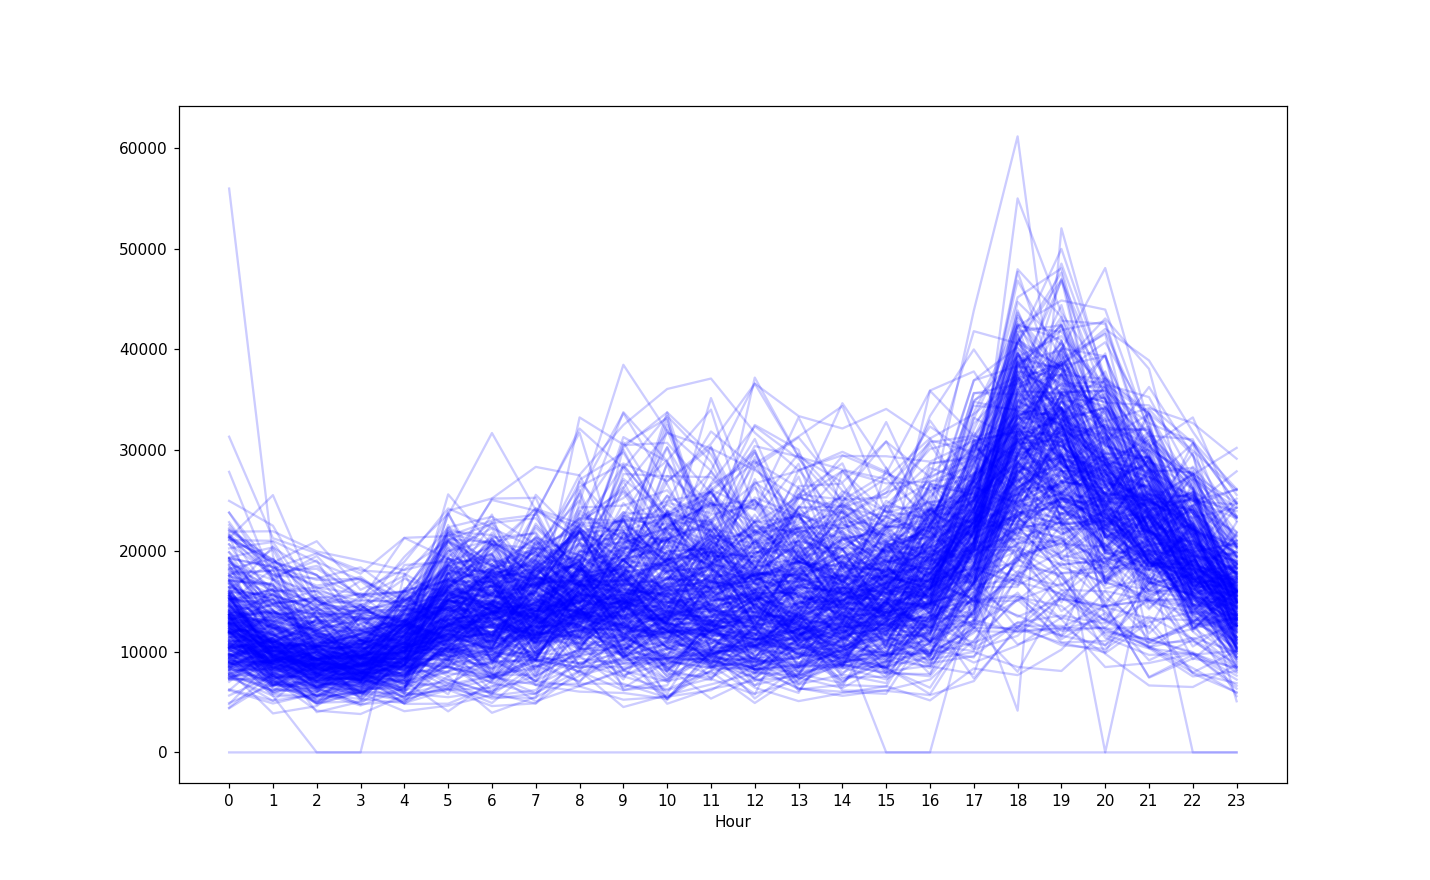

In [26]:
### Residential Load Profiles

DF_pivot = display_load(residential)

a = DF_pivot.T.plot(figsize=(13,8), legend=False, color='blue', alpha=0.2)
a.set(xticks = range(0,24),xlabel='Hour', xticklabels = range(0,24))
plt.show()


<IPython.core.display.Javascript object>


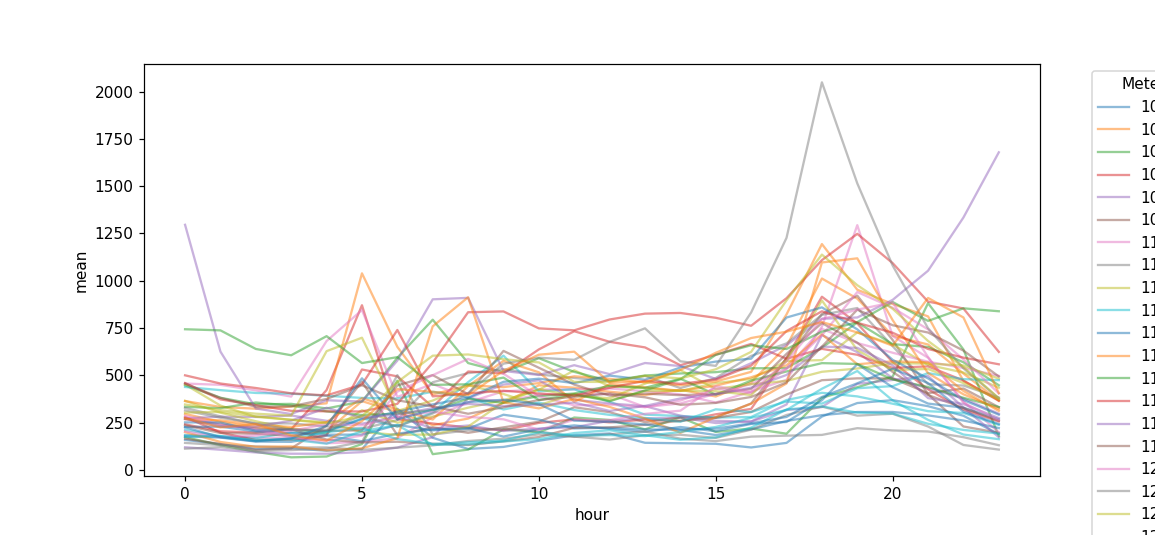

In [27]:
### Residential Load Profiles - Average Daily profile

data_df =  df_energy[df_energy["meter"]==10200]
data_df = data_df.groupby(['hour','meter'])['ActiveEnergy_log'].sum().reset_index()
data_df["mean"]= data_df['ActiveEnergy_log']/365



for i in range(10300,14800,100):
    mr =df_energy[df_energy["meter"]==i]
    mr = mr.groupby(['hour','meter'])['ActiveEnergy_log'].sum().reset_index()
    mr["mean"]= mr['ActiveEnergy_log']/365
    data_df = data_df.append(mr)

data_df

for meter in data_df.meter.unique():
    data = data_df[data_df.meter == meter]
    sns.lineplot(data["hour"], data["mean"], label=meter, alpha = 0.5)
    plt.legend(title='Meter',bbox_to_anchor=(1.05,1),loc='upper left')


<IPython.core.display.Javascript object>


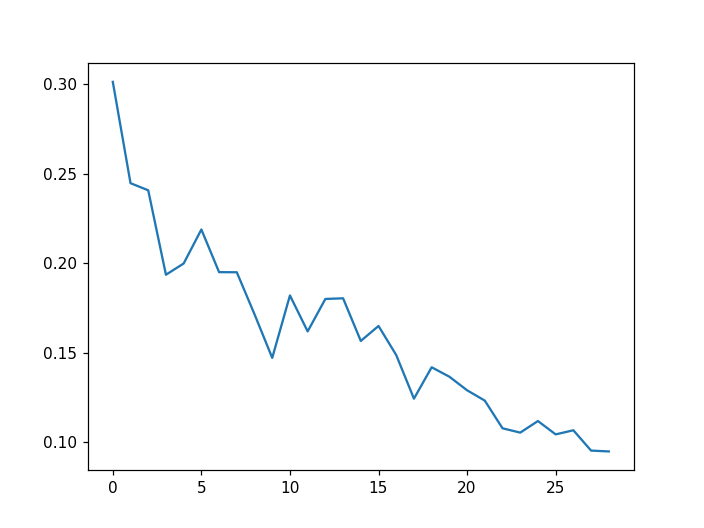

<IPython.core.display.Javascript object>


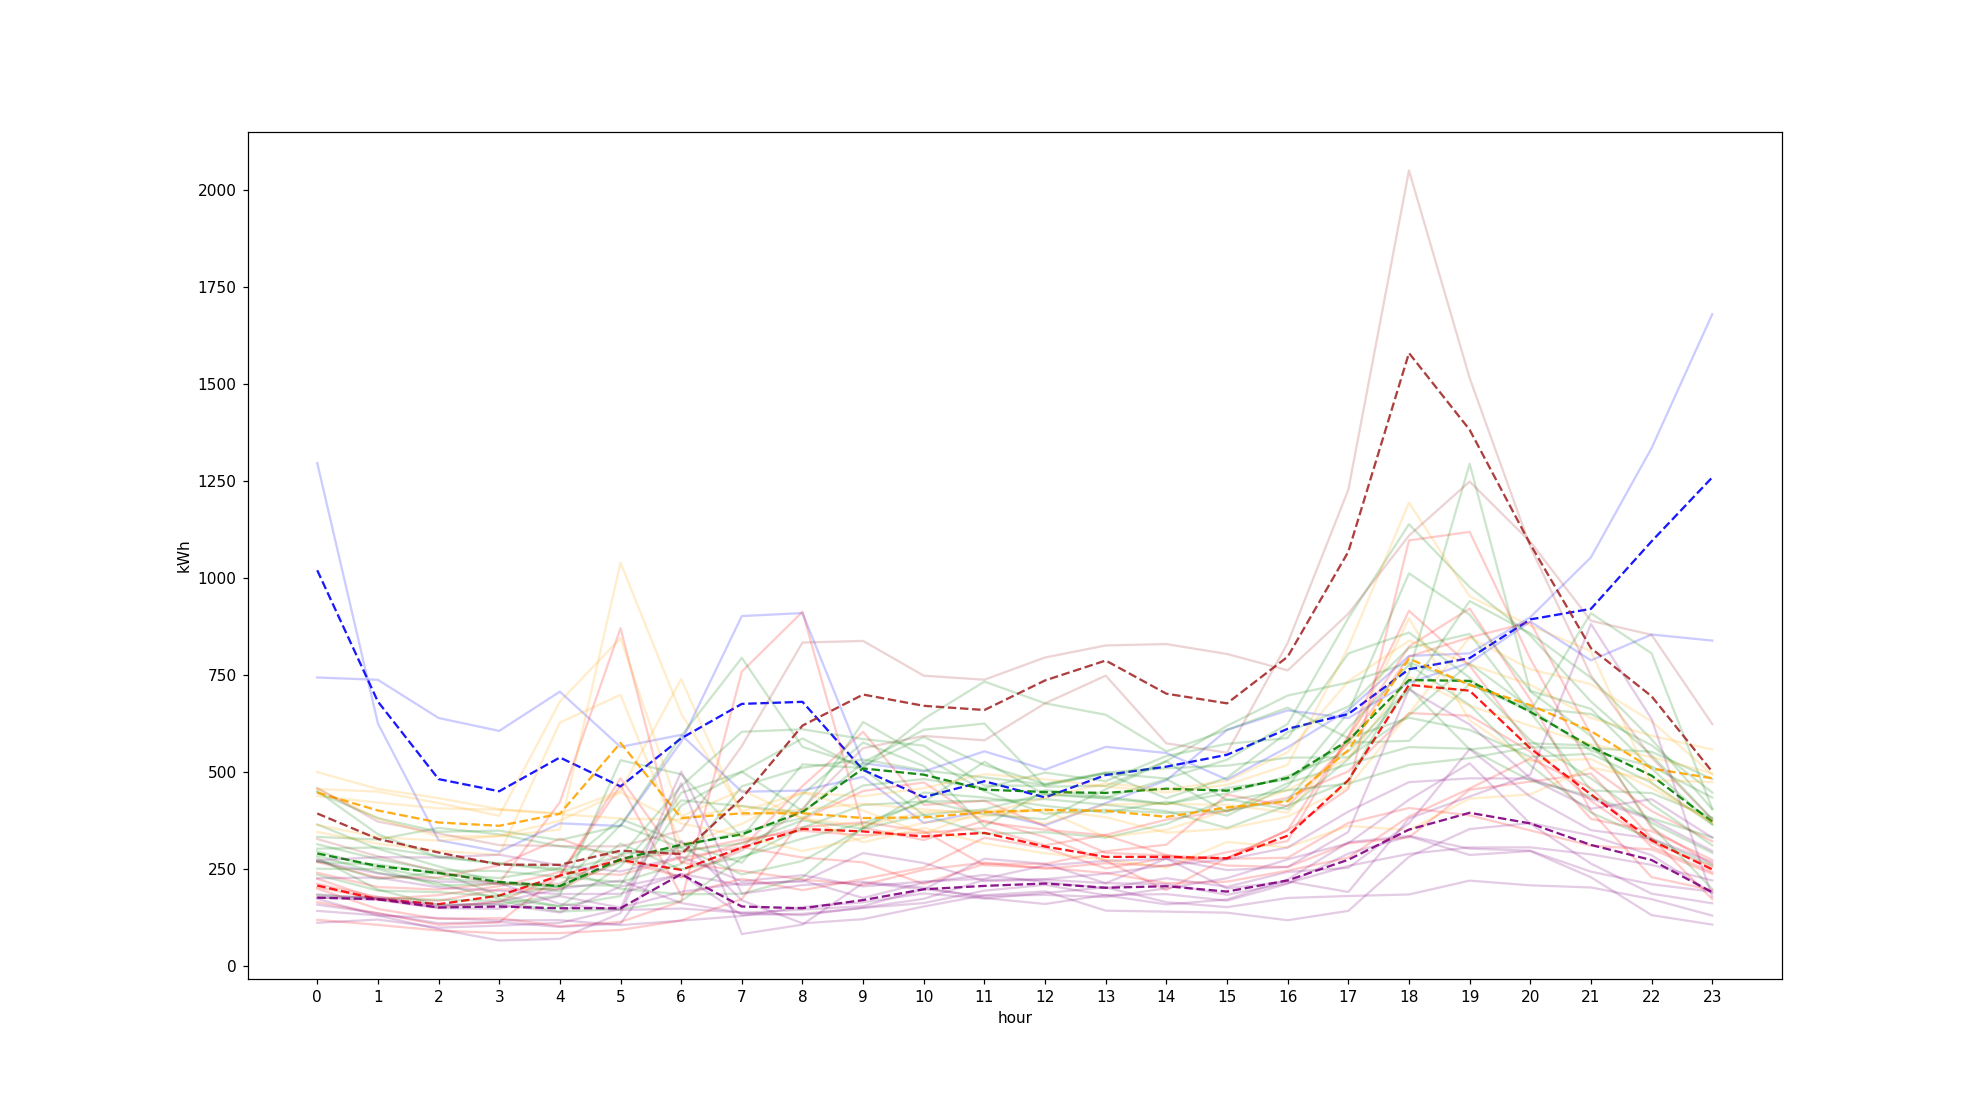

Text(0.5, 0, 'hour')

In [28]:
### Residential Clusters 
##  Note that the fit.predict will change the output each time it is run
c = data_df[['mean','meter','hour']]
c = c.set_index('meter')

c_pivot = c.pivot(columns='hour')

silhouette_scores = []
n_cluster_list = np.arange(2,31).astype(int)

X = c_pivot.values.copy()

sc = MinMaxScaler()
X = sc.fit_transform(X)

for n_cluster in n_cluster_list:
    kmeans = KMeans(n_clusters = n_cluster)
    cluster_found = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X,kmeans.labels_))

fig,ax = plt.subplots()
ax.plot(range(29),silhouette_scores)


kmeans = KMeans(n_clusters=6)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name='cluster')
c_pivot= c_pivot.set_index(cluster_found_sr, append=True )

fig, ax= plt.subplots(1,1, figsize=(18,10))
colour_list = ['blue','red','green','orange','purple','brown']


cluster_values = sorted(c_pivot.index.get_level_values('cluster').unique())

for cluster,colour in zip(cluster_values,colour_list):
    c_pivot.xs(cluster, level=1).T.plot(ax=ax, legend=False, alpha=0.2, color=colour, label= f'Cluster {cluster}')
    c_pivot.xs(cluster, level=1).median().plot(ax=ax, color=colour, alpha=0.9, ls='--')

ax.set_xticks(range(0,24))
ax.set_xticklabels(range(0,24))
ax.set_ylabel('kWh')
ax.set_xlabel('hour')

In [29]:
### Manual Clustering from observing initial clusters provided by the clustering function


Evening_peak = c_pivot.loc[[10800,10900,12800,10500,11000,11100,11200,11400,11700,11800,11900,12300,12500,12600,12700,13000,13100,13200,13500,13600,13800,14000,14100,14200,14300,14400,14500,14700]]
Late_night_peak =  c_pivot.loc[[12400,12900]]
Double_peak = c_pivot.loc[[10200,10600,10700,11600,11500,12100,13400,13700,13900,14600]]
Morning_peak = c_pivot.loc[[11300,12200]]


<IPython.core.display.Javascript object>


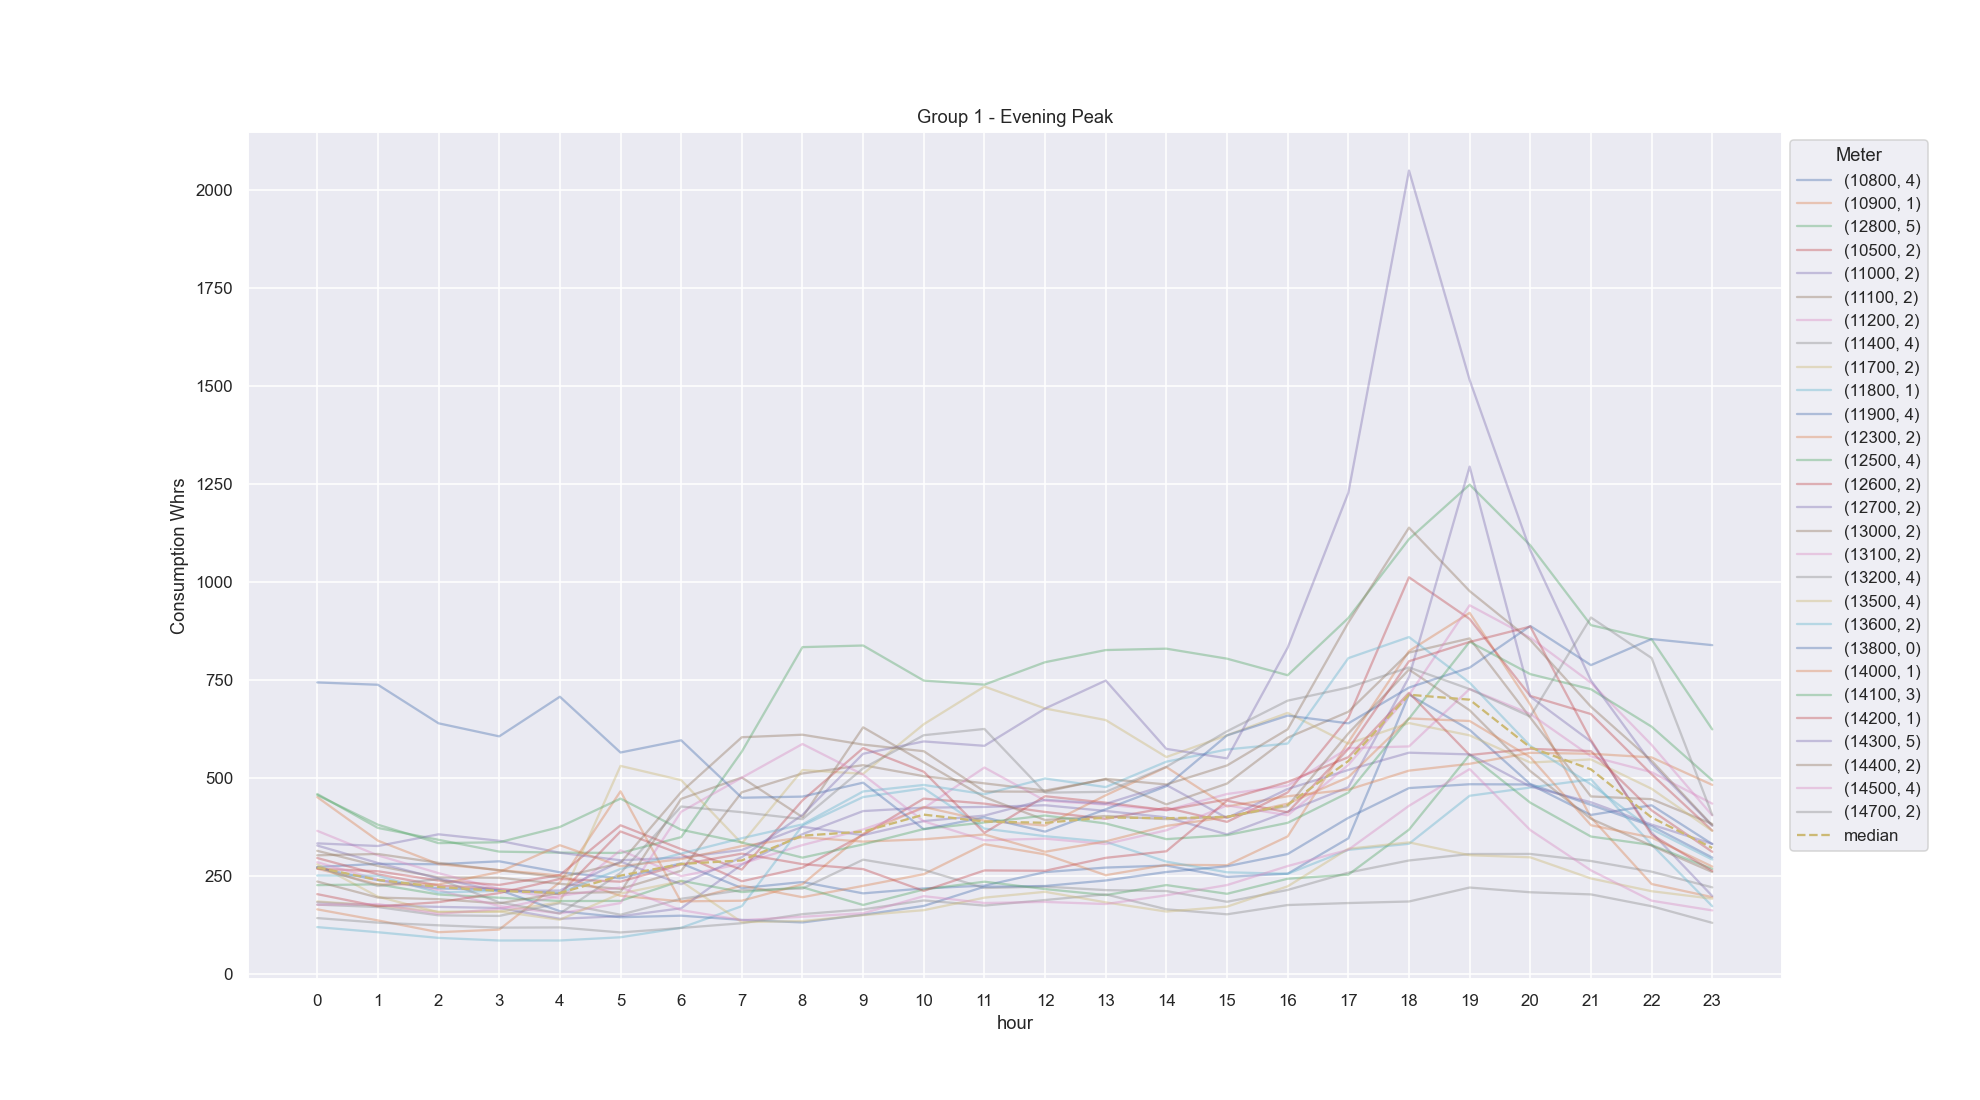

<IPython.core.display.Javascript object>


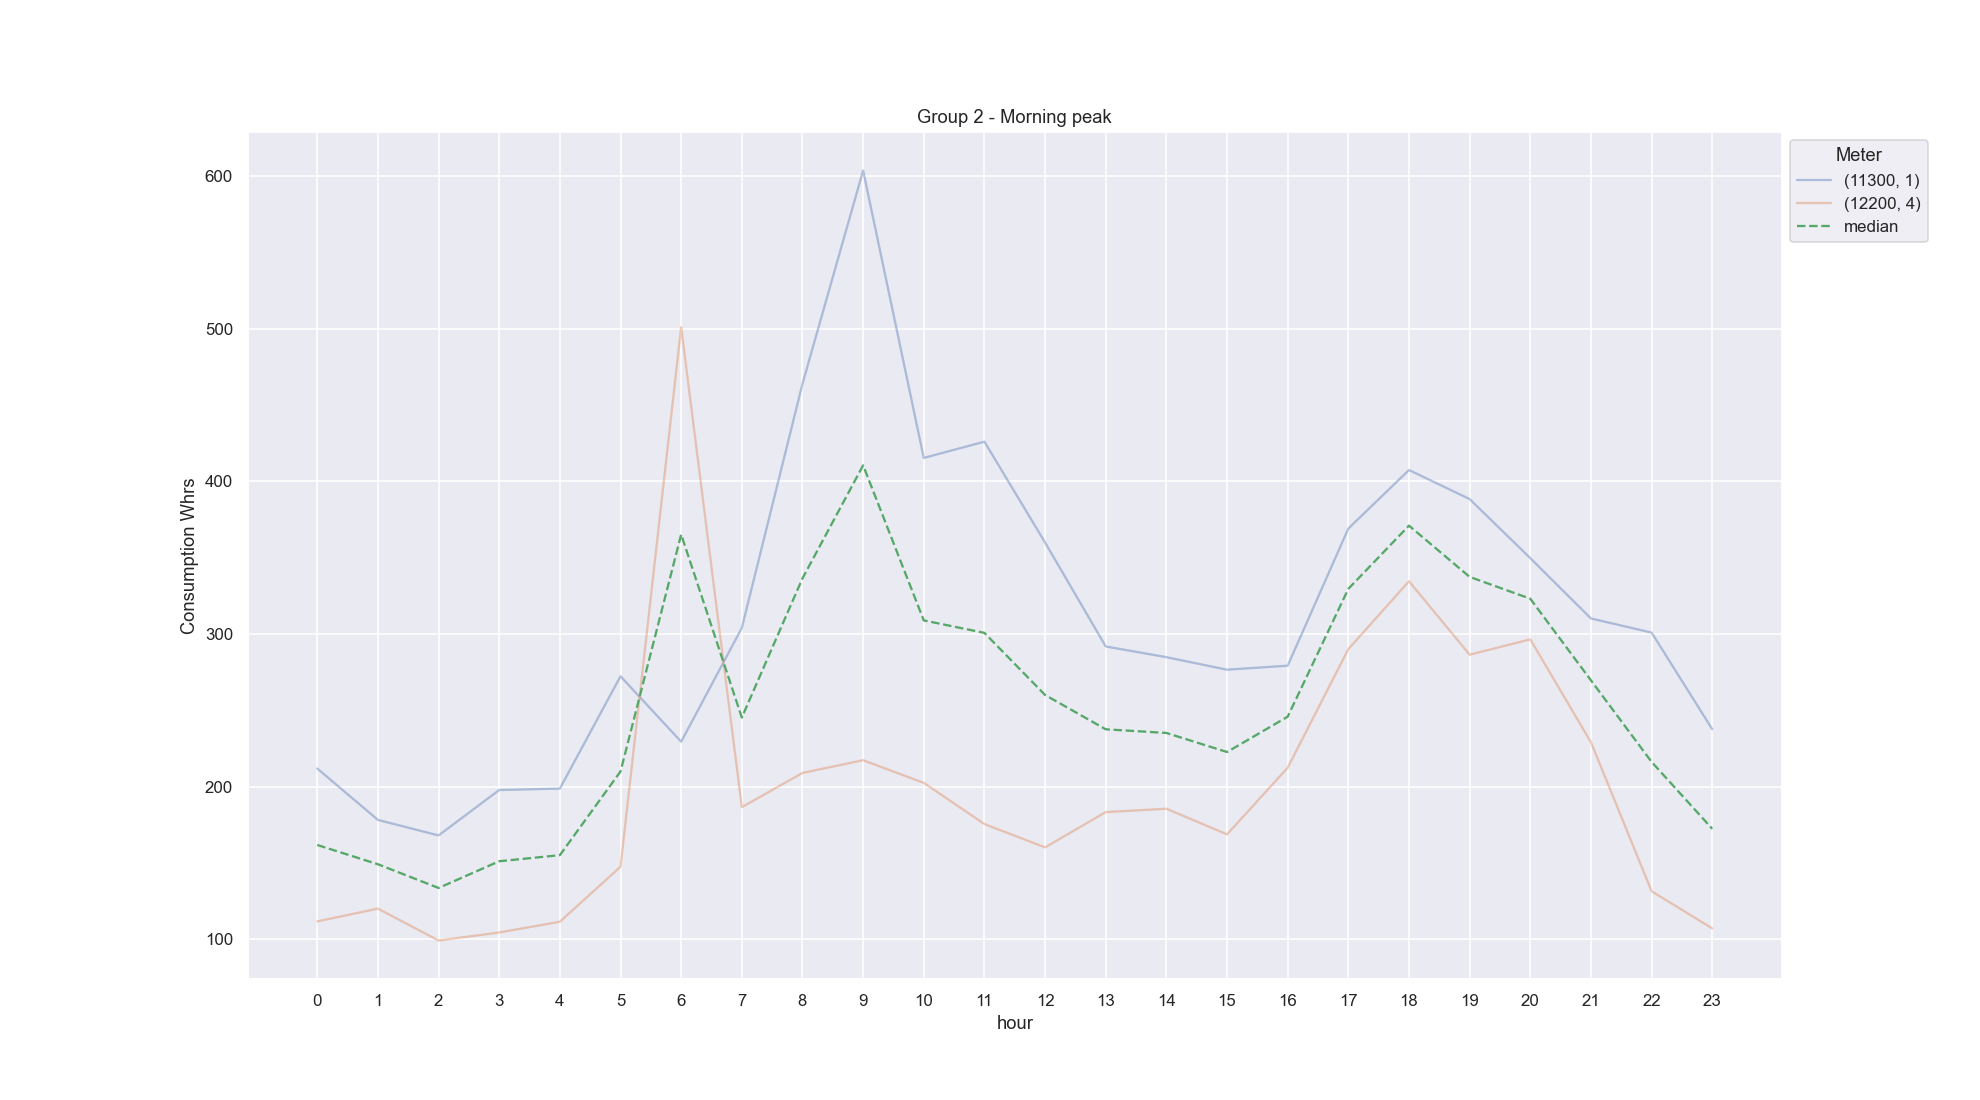

<IPython.core.display.Javascript object>


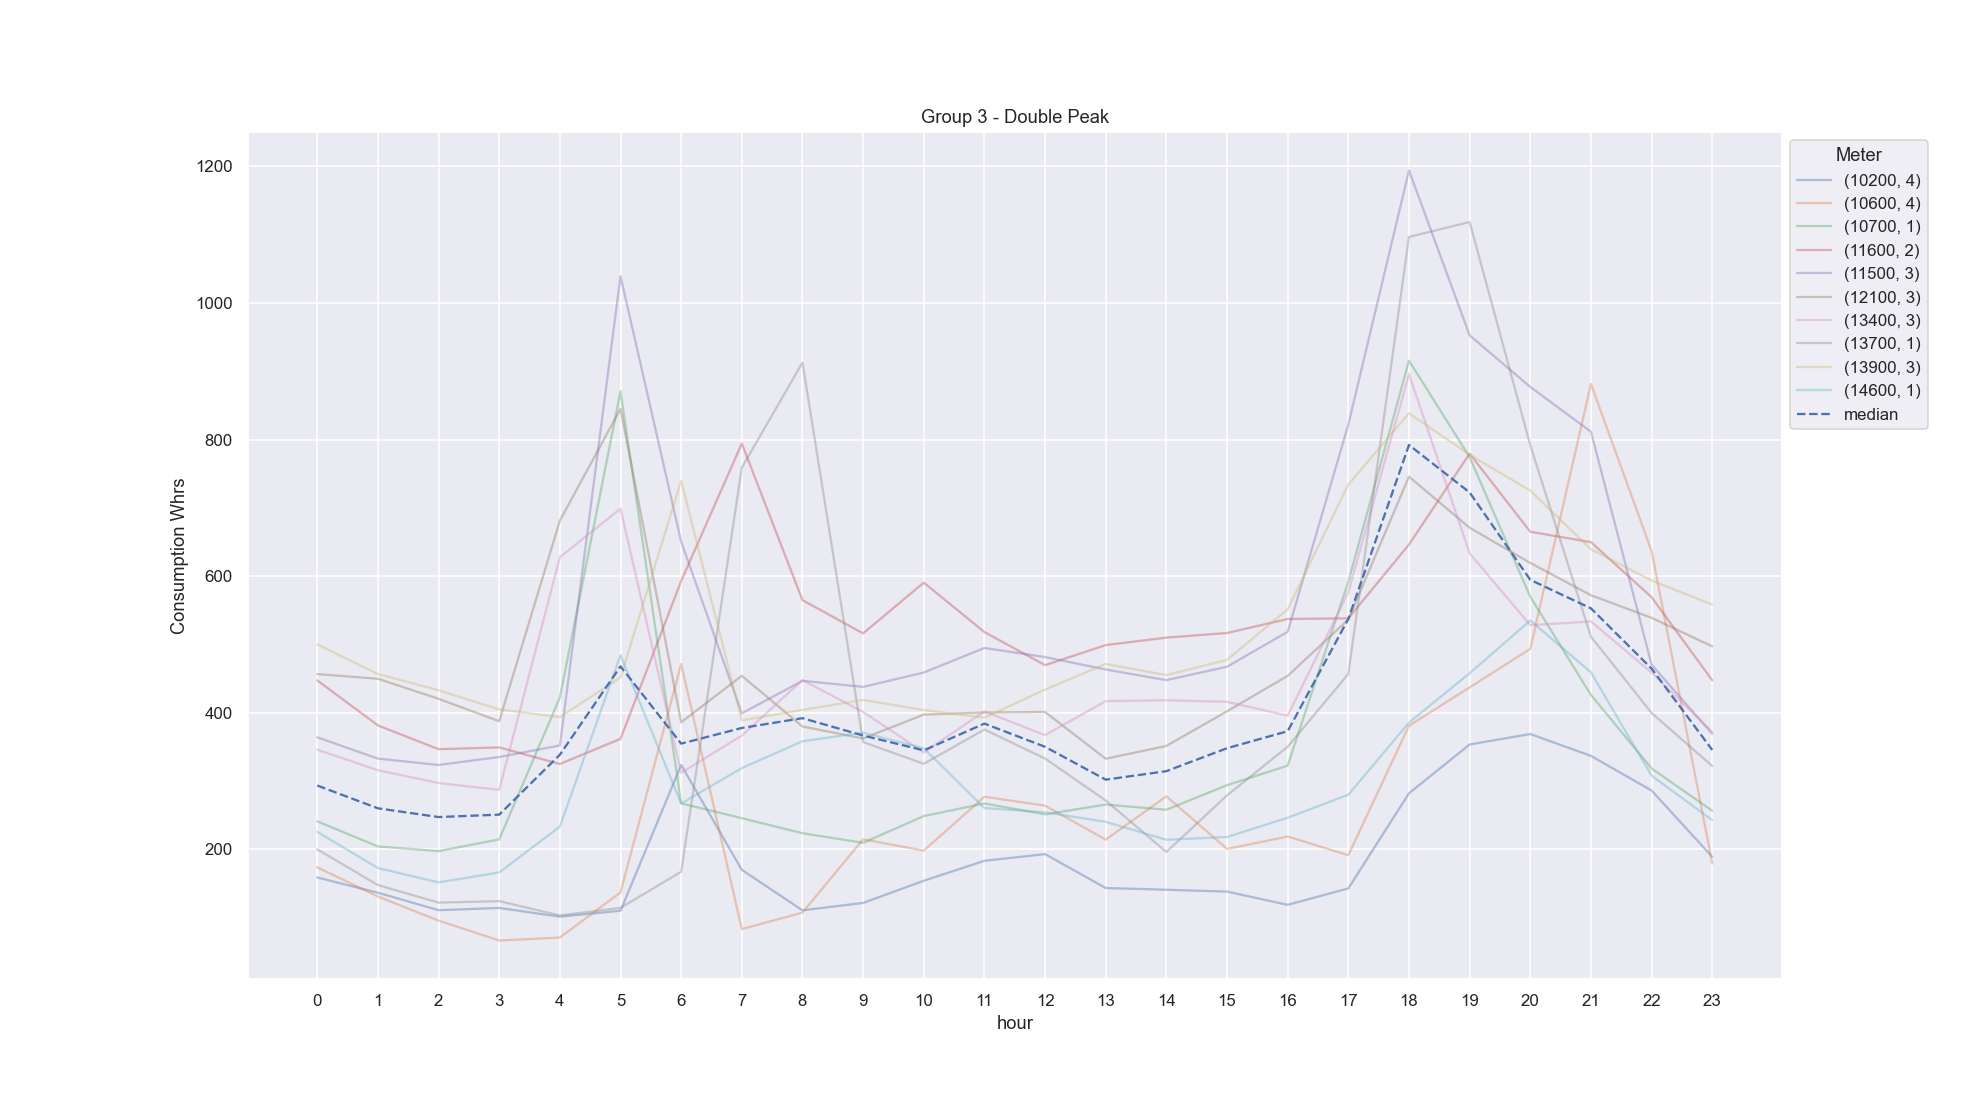

<IPython.core.display.Javascript object>


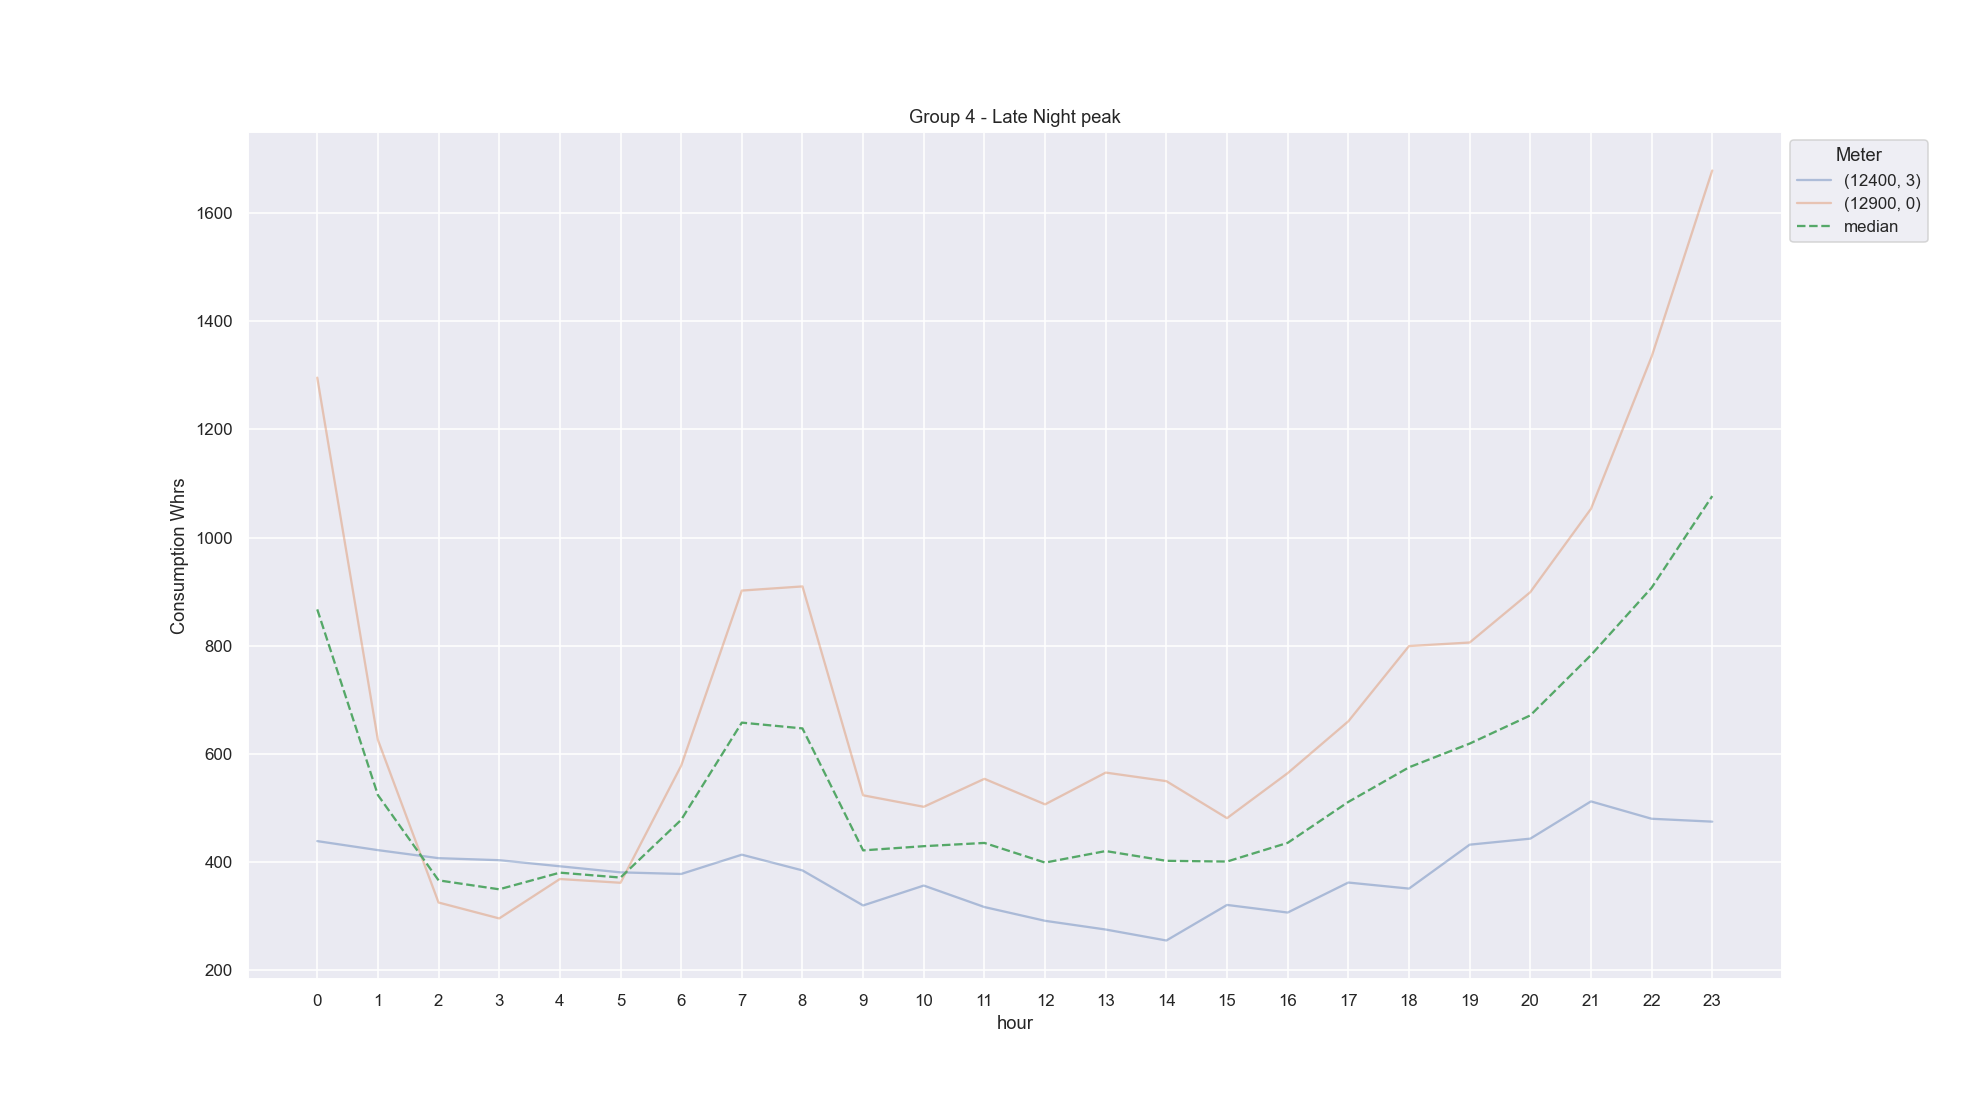

In [30]:
### Plot Separate Load Profile Clusters 
sns.set(rc={'figure.figsize': (11, 4)})
sns.set(style='darkgrid')
fig, ax= plt.subplots(1,1, figsize=(18,10))
Evening_peak.T.plot(ax = ax,alpha = 0.4)
Evening_peak.median().plot(ax = ax, ls='--',label='median',alpha =1)
ax.set(xticks = range(24),xticklabels = range(24),xlabel = 'hour',ylabel = 'Consumption Whrs',title='Group 1 - Evening Peak')
plt.legend(title='Meter',bbox_to_anchor=(1,1),loc='upper left')


fig, ax = plt.subplots(1,1, figsize=(18,10))
Morning_peak.T.plot(ax = ax,alpha = 0.4)
Morning_peak.median().plot(ax = ax, ls='--',label='median',alpha = 1)
ax.set(xticks = range(24),xticklabels = range(24),xlabel = 'hour',ylabel = 'Consumption Whrs',title='Group 2 - Morning peak')
plt.legend(title='Meter',bbox_to_anchor=(1,1),loc='upper left')

fig, ax = plt.subplots(1,1, figsize=(18,10))
Double_peak.T.plot(ax = ax,alpha = 0.4)
Double_peak.median().plot(ax = ax, ls='--',label='median',alpha = 1)
ax.set(xticks = range(24),xticklabels = range(24),xlabel = 'hour',ylabel = 'Consumption Whrs',title='Group 3 - Double Peak')
plt.legend(title='Meter',bbox_to_anchor=(1,1),loc='upper left')

fig, ax= plt.subplots(1,1, figsize=(18,10))
Late_night_peak.T.plot(ax = ax,alpha = 0.4)
Late_night_peak.median().plot(ax = ax, ls='--',label='median',alpha = 1)
ax.set(xticks = range(24),xticklabels = range(24),xlabel = 'hour',ylabel = 'Consumption Whrs',title='Group 4 - Late Night peak')
plt.legend(title='Meter',bbox_to_anchor=(1,1),loc='upper left')


<IPython.core.display.Javascript object>


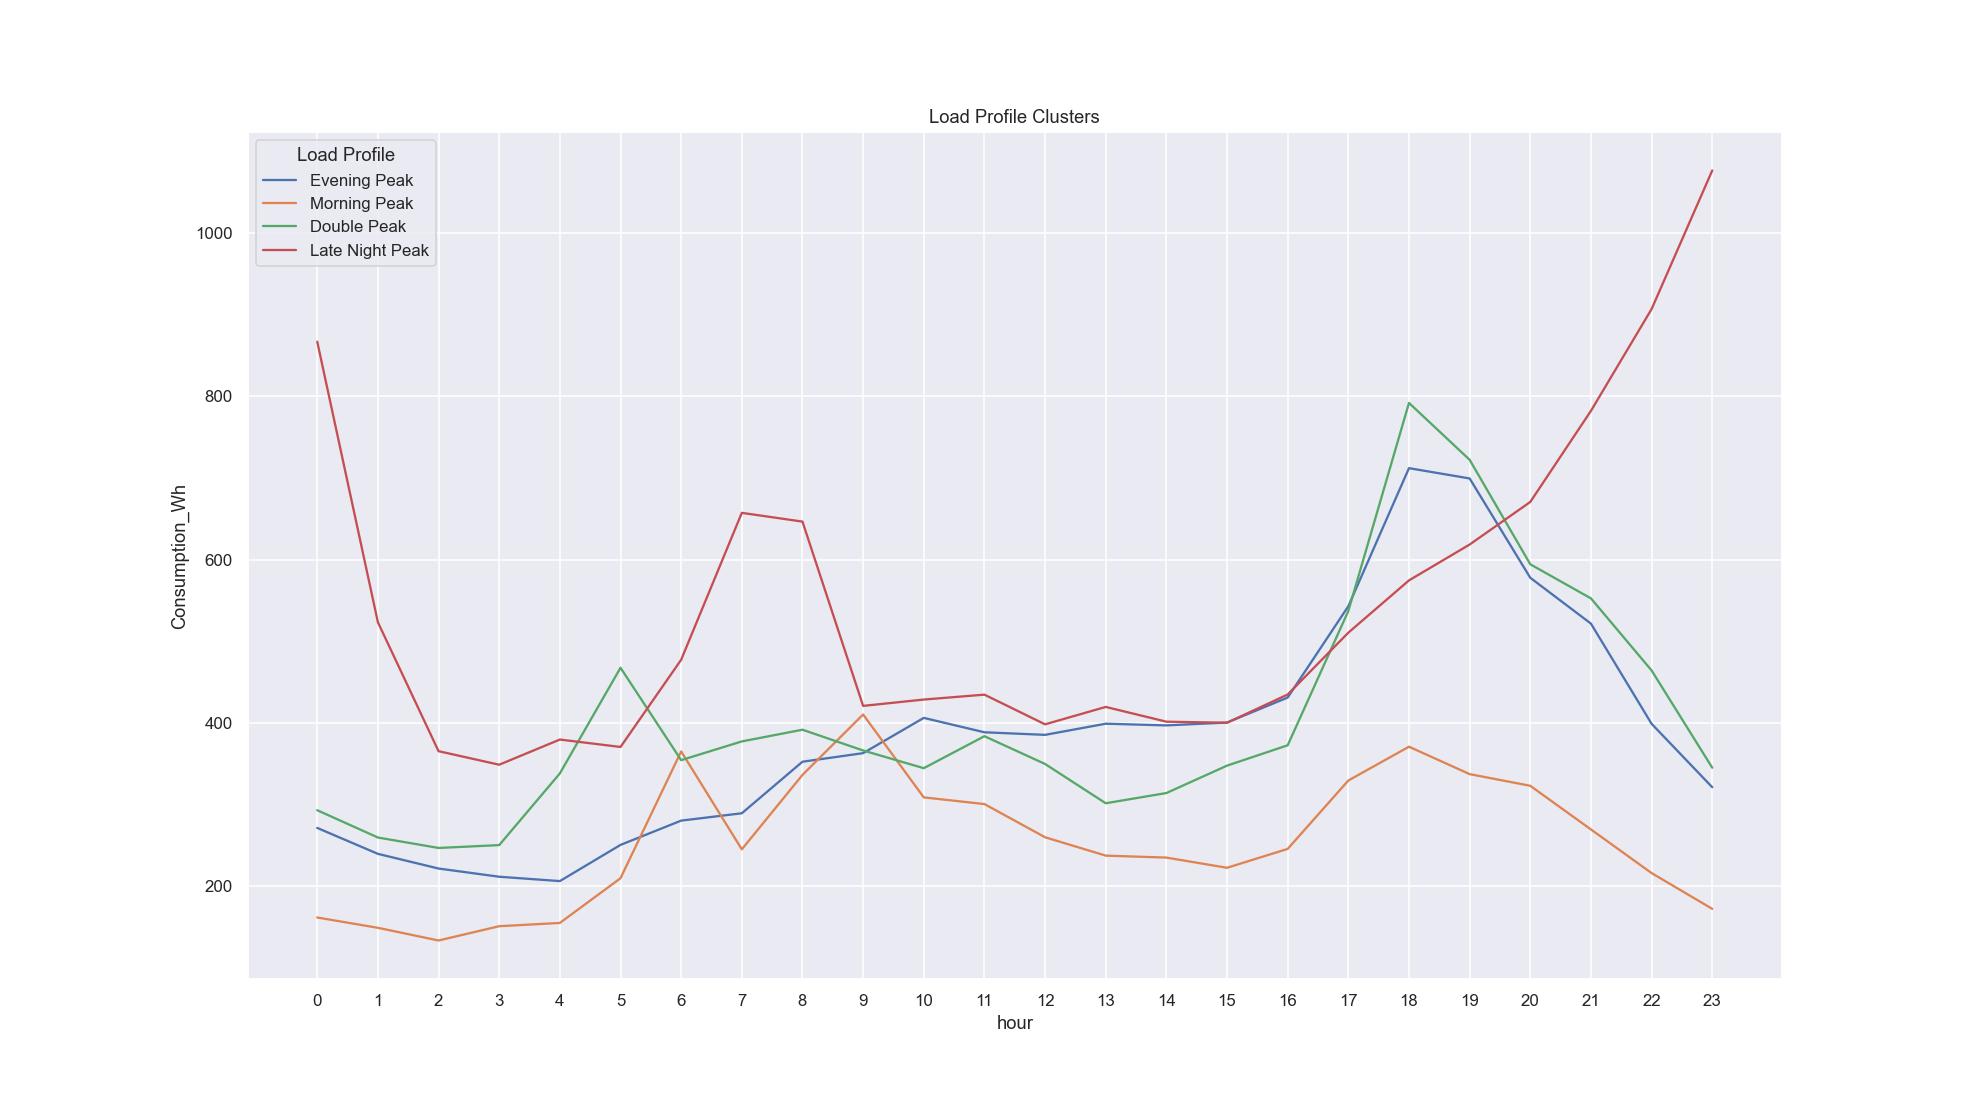

Text(0.5, 1.0, 'Load Profile Clusters')

In [31]:
### Plot Each type of Load Profile 
sns.set(rc={'figure.figsize': (11, 4)})
sns.set(style='darkgrid')

fig, ax= plt.subplots(1,1, figsize=(18,10))
Evening_peak.median().plot(ax = ax,alpha =1,label='Evening Peak')
Morning_peak.median().plot(ax = ax,alpha =1, label ='Morning Peak')
Double_peak.median().plot(ax = ax,alpha =1, label = 'Double Peak')
Late_night_peak.median().plot(ax = ax,alpha =1, label = 'Late Night Peak')
plt.legend(title='Load Profile',loc='upper left')
plt.xticks(range(24),range(24))
plt.ylabel('Consumption_Wh')
plt.xlabel('hour')
plt.title('Load Profile Clusters')

In [44]:
### PROFILE B assumption
total_building_profile_B = [13734,13734,13734,13734,13734,22890,22890,45024,45024,19068,19068,19068,19068,19068,19068,19068,51778,67536,67536,45024,45024,29757,22890,13734]
ave_occupancy_rate = 0.93 
production_rate_forecast = 3.8
PV_system_size = 50

PV_profile = [0,0,0,0,0,0,0,32,192,448,544,595.2,608,595.2,544,448,192,32,0,0,0,0,0,0] ### 4.2 baseline production rate

Profile_B = pd.DataFrame(columns=["hour","total_building_profile_Wh","daily_ave_load_kW","PV_profile_base","PV_profile","grid_load_profile"])

Profile_B["hour"] = range(24)
Profile_B["total_building_profile_Wh"] = total_building_profile_B
Profile_B["daily_ave_load_kW"] = (Profile_B["total_building_profile_Wh"]/1000)*ave_occupancy_rate
Profile_B["PV_profile_base"] = PV_profile
Profile_B["PV_profile"] = ((Profile_B["PV_profile_base"]*PV_system_size)*(production_rate_forecast/4.2))/1000
Profile_B["grid_load_profile"] = Profile_B["daily_ave_load_kW"] - Profile_B["PV_profile"]
Profile_B["Actual_ave_load"] = Site_consumption.groupby(['hour'])['ActiveEnergy_log'].median()
Profile_B["ave_load_diff"] =(( Profile_B["Actual_ave_load"]-Profile_B["daily_ave_load_kW"] )/Profile_B["daily_ave_load_kW"])*100

Profile_B

hour  total_building_profile_Wh  daily_ave_load_kW  PV_profile_base  \
0      0                      13734           12.77262              0.0   
1      1                      13734           12.77262              0.0   
2      2                      13734           12.77262              0.0   
3      3                      13734           12.77262              0.0   
4      4                      13734           12.77262              0.0   
5      5                      22890           21.28770              0.0   
6      6                      22890           21.28770              0.0   
7      7                      45024           41.87232             32.0   
8      8                      45024           41.87232            192.0   
9      9                      19068           17.73324            448.0   
10    10                      19068           17.73324            544.0   
11    11                      19068           17.73324            595.2   
12    12                      19068           17.73324            608.0   
13    13                      19068           17.73324            595.2   
14    14                      19068           17.73324            544.0   
15    15                      19068           17.73324            448.0   
16    16                      51778           48.15354            192.0   
17    17                      67536           62.80848             32.0   
18    18                      67536           62.80848              0.0   
19    19                      45024           41.87232              0.0   
20    20                      45024           41.87232              0.0   
21    21                      29757           27.67401              0.0   
22    22                      22890           21.28770              0.0   
23    23                      13734           12.77262              0.0   

    PV_profile  grid_load_profile  Actual_ave_load  ave_load_diff  
0     0.000000          12.772620          13.8570       8.489879  
1     0.000000          12.772620          11.3095     -11.455128  
2     0.000000          12.772620          10.5085     -17.726355  
3     0.000000          12.772620          10.2965     -19.386156  
4     0.000000          12.772620          11.6480      -8.804928  
5     0.000000          21.287700          15.0745     -29.186807  
6     0.000000          21.287700          15.9195     -25.217379  
7     1.447619          40.424701          15.9520     -61.903233  
8     8.685714          33.186606          17.3605     -58.539436  
9    20.266667          -2.533427          17.3030      -2.426178  
10   24.609524          -6.876284          17.3015      -2.434637  
11   26.925714          -9.192474          17.3520      -2.149861  
12   27.504762          -9.771522          17.2150      -2.922421  
13   26.925714          -9.192474          16.9100      -4.642355  
14   24.609524          -6.876284          17.2460      -2.747608  
15   20.266667          -2.533427          17.9435       1.185683  
16    8.685714          39.467826          19.5710     -59.357090  
17    1.447619          61.360861          24.3085     -61.297424  
18    0.000000          62.808480          31.7770     -49.406513  
19    0.000000          41.872320          31.7750     -24.114546  
20    0.000000          41.872320          27.4970     -34.331320  
21    0.000000          27.674010          24.5180     -11.404238  
22    0.000000          21.287700          20.3300      -4.498842  
23    0.000000          12.772620          16.5185      29.327421

Common Area consumption percentage of Residential consumption 11.058723934408397


<IPython.core.display.Javascript object>


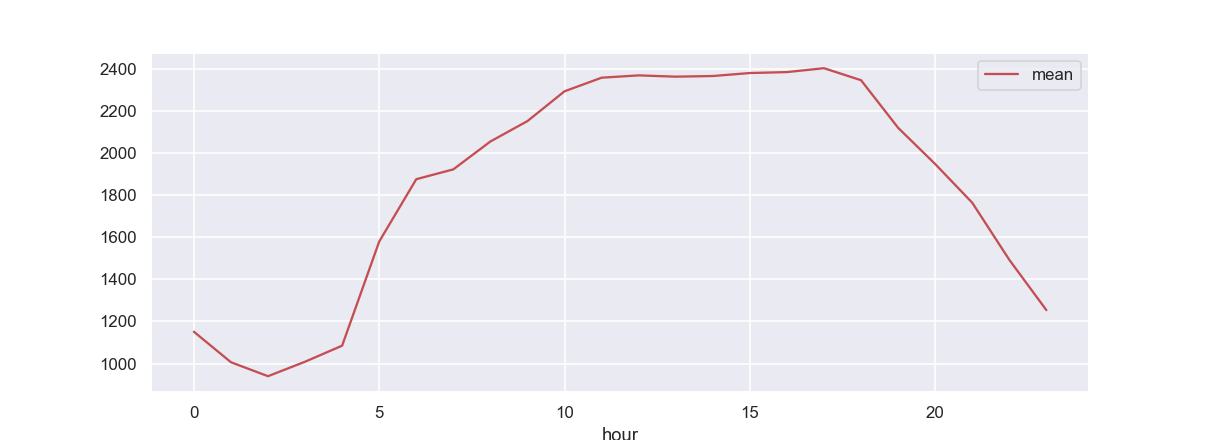

<AxesSubplot:xlabel='hour'>

In [34]:
### Common Area consumption as a percentage of Residential consumption
print("Common Area consumption percentage of Residential consumption",(House["ActiveEnergy_log"].sum()/Residential["ActiveEnergy_log"].sum())*100)
house_df =  House.groupby(['hour'])['ActiveEnergy_log'].sum().reset_index()
house_df["mean"] = house_df["ActiveEnergy_log"]/366
house_df
house_df.plot(x="hour",y="mean",c = "r")

In [35]:
comp = residential.groupby(["month","hour"])["ActiveEnergy_log"].sum().reset_index()
comp_house = house.groupby(["month","hour"])["ActiveEnergy_log"].sum().reset_index()
comp["common_area"]=comp_house["ActiveEnergy_log"]
comp["ratio_%"]=(comp["common_area"]/comp["ActiveEnergy_log"])*100
comp
### Average ratio of common area consumption over residential unit consumption
# comp["ratio_%"].mean() = 11.767546722838754
## correlation between common area consumption and residential units consumption varies during the day

month  hour  ActiveEnergy_log  common_area    ratio_%
0     January     0          272466.0      40733.0  14.949755
1     January     1          256827.0      34387.0  13.389169
2     January     2          221572.0      34777.0  15.695575
3     January     3          224924.0      34011.0  15.121108
4     January     4          218144.0      34648.0  15.883086
..        ...   ...               ...          ...        ...
283  December    19          758482.0      68365.0   9.013398
284  December    20          736193.0      68257.0   9.271618
285  December    21          696487.0      60939.0   8.749481
286  December    22          647387.0      52232.0   8.068126
287  December    23          519114.0      47579.0   9.165424

[288 rows x 5 columns]

## Visualisation of Data
Plots currently visualise ActiveEnergy_Consumption data only

In [36]:
### Create Pivot Tables
months = list(EnergyConsumption_df["month"].unique())

### Pivot Tables for ActiveEnergy_consumption_kWh
# Below pivot tables used for plots 
pivot = df_energy.pivot_table(values='ActiveEnergy_log',index='time', columns='meter')

###Total consumption for the hour
hourly_consumption = pivot.resample("H").sum() 
hourly_stat = hourly_consumption.agg([np.sum,np.mean,np.std,np.min,np.max])

### Total consumption on each day 
daily = hourly_consumption.resample("D")
daily_total  = daily.sum() 
daily_stat = daily.agg([np.sum,np.mean,np.std,np.min,np.max])

### Total consumption for the month 
monthly= daily_total.resample("M")
monthly_total = monthly.sum(min_count=28)
monthly_total = monthly_total.set_index([pd.Index(range(len(months)))])
monthly_total.insert(0,"month",months)
monthly_stat = monthly.agg([np.sum,np.mean,np.std,np.min,np.max])

In [ ]:
### Figure - Hourly Consumption 
sns.set(rc={'figure.figsize': (11, 4)})
sns.set(style='darkgrid')
hourly_consumption.loc[:,10000:10300].plot()
plt.ylabel("Energy consumption (kWh)")
plt.title("Total Consumption per Hour")
plt.legend(loc = "upper left",ncol=2)

### Figure - Hourly Consumption Residential 
for met in range(10200,14700,1200):
    sns.set(rc={'figure.figsize': (11, 4)})
    sns.set(style='darkgrid')
    hourly_consumption.loc[:,met:met+1100].plot()
    plt.ylabel("Energy consumption (kWh)")
    plt.title("Total Consumption per Hour")
    plt.legend(loc = "upper left",ncol=2)
    
###  Figure 2 - Daily Consumption for Check Meter (10000) and House Meter (10100)
sns.set(rc={'figure.figsize': (15, 5)})
daily_total.loc[:,10000:10100].plot(kind ='line')
plt.ylabel("Energy consumption (kWh)")
plt.title("Total Consumption per Day")
plt.legend(loc = "upper left",ncol=1)
plt.subplots_adjust(bottom = 0.2, top = 0.9, wspace = 0.2, hspace= 0.4)


### Residential 
for met in range(10200,14700,1200):
    sns.set(rc={'figure.figsize': (15, 5)})
    daily_total.loc[:,met:met+1100].plot()
    plt.ylabel("Energy consumption (kWh)")
    plt.title("Total Consumption per Day")
    plt.legend(loc = "upper left",ncol=2)
    plt.subplots_adjust(bottom = 0.2, top = 0.9, wspace = 0.2, hspace= 0.4)

<IPython.core.display.Javascript object>


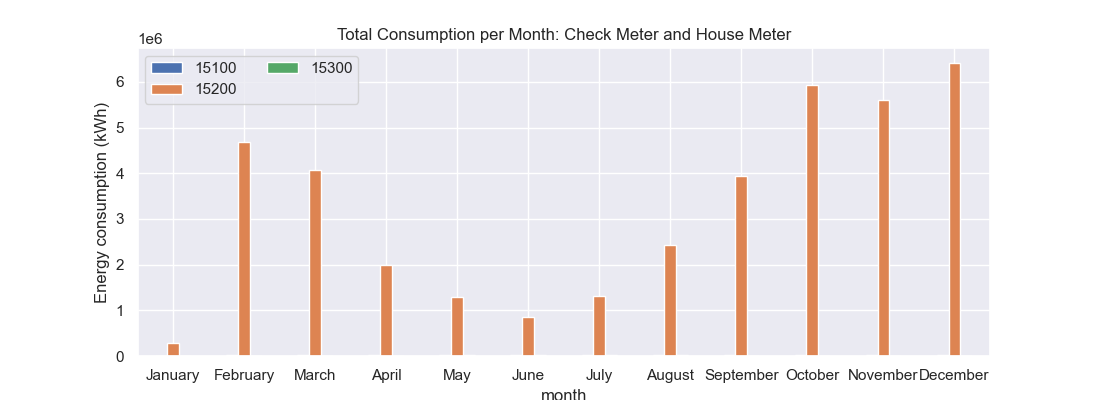

<IPython.core.display.Javascript object>


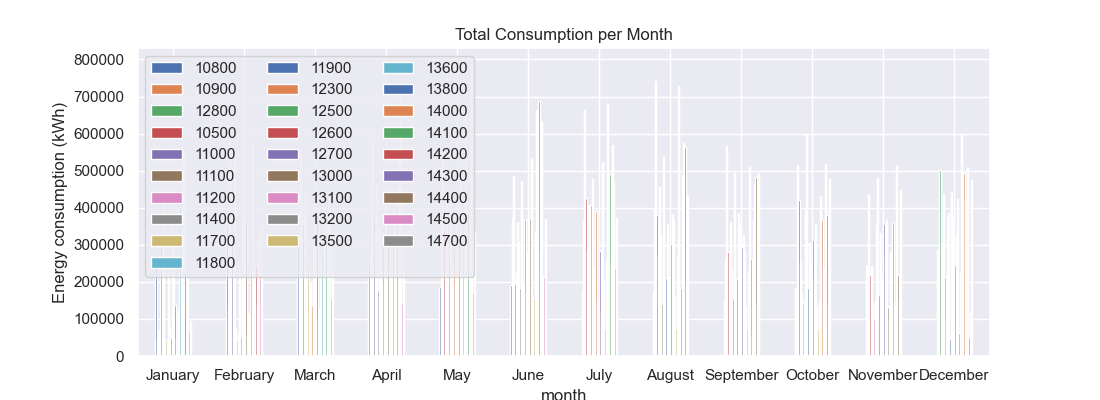

<IPython.core.display.Javascript object>


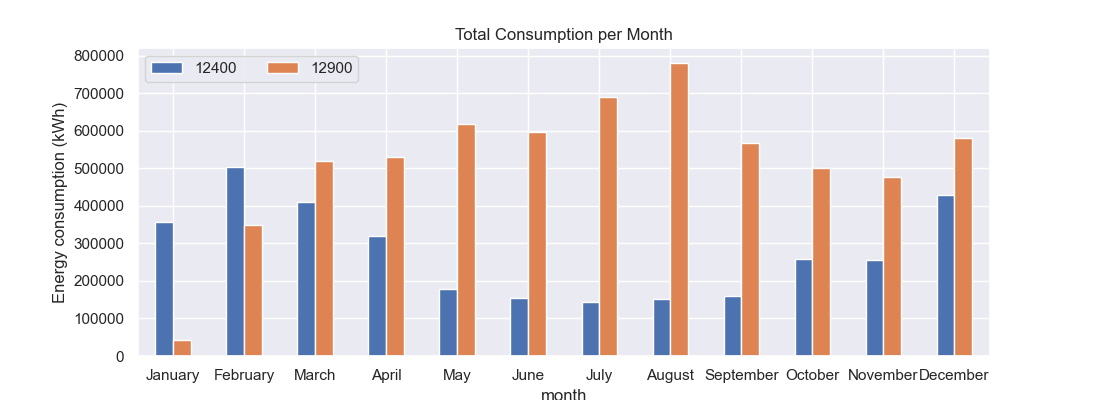

<IPython.core.display.Javascript object>


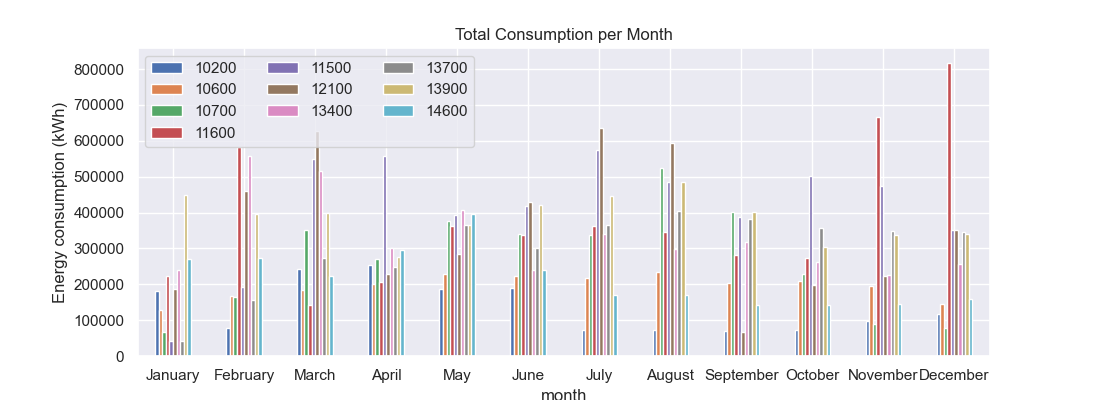

<IPython.core.display.Javascript object>


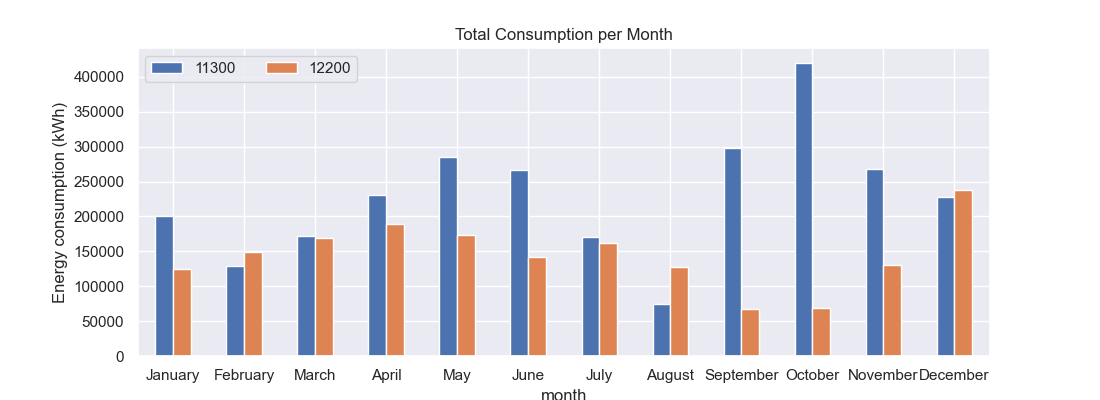

In [79]:
### Figure 3 - Monthly Consumption

E_monthly.pivot('month','meter','ActiveEnergy_log').loc[:,[15100,15300]].plot(kind='bar')
plt.title("Total Consumption per Month: Check Meter and House Meter")
plt.ylabel("Energy consumption (kWh)")
plt.xticks(rotation=0)
plt.legend(loc = 'upper left',ncol=2)

Evening_cluster = [10800,10900,12800,10500,11000,11100,11200,11400,11700,11800,11900,12300,12500,12600,12700,13000,13100,13200,13500,13600,13800,14000,14100,14200,14300,14400,14500,14700]
Late_night_cluster =  [12400,12900]
Double_cluster = [10200,10600,10700,11600,11500,12100,13400,13700,13900,14600]
Morning_cluster =[11300,12200]

### Figure 3 - Monthly Consumption residential units
## may be adjusted to separate into clusters based on level,bedrooms etc
for grp in[Evening_cluster,Late_night_cluster,Double_cluster,Morning_cluster]:
    E_monthly.pivot('month','meter','ActiveEnergy_log').loc[:,grp].plot(kind='bar')
    plt.title('Total Consumption per Month')
    plt.ylabel("Energy consumption (kWh)")
    plt.legend(loc = 'upper left',ncol=3)
    plt.xticks(rotation=0)

# monthly_total.plot(kind='line')

### Modelling residential occupancy type

Evening peak - less likely for units with younger children (children older than 12)
Type A - 1 adult
Type B - 2 adults or 1 adult, 1 child
Type C - 1 adult, 2 children
Type D - 2 adults, 1 child

Double peak - higher peak(families with children), lower peaks(working adults)
Type A - 1 adult
Type B - 1 adult, 1 child
Type C - 1 adult, 2 children or 2 adults
Type D - 2 adults 1 child or more

Morning peak - work, elderly/retired, younger children 
Type A(1 adult, 1 child) or 1 adult
Type B(2 elderly adults or 1 adult,2 children)

Late night peak - no children 
Type A (1 adult)
Type D (2 adults,shift work)

In [181]:
### Categorising Consumption based on total Monthly consumption
mt = (residential.groupby(["meter","month"])[["ActiveEnergy_log"]].sum()/1000).reset_index()
mt.loc[(mt['ActiveEnergy_log'] <=250),'Type'] = 'A'
mt.loc[((mt['ActiveEnergy_log'] > 250) & (mt['ActiveEnergy_log'] <=350)),'Type'] = 'B'
mt.loc[((mt['ActiveEnergy_log'] > 350) & (mt['ActiveEnergy_log'] <=500)),'Type']= 'C'
mt.loc[((mt['ActiveEnergy_log'] > 500) & (mt['ActiveEnergy_log'] <=600)),'Type']= 'D'
mt.loc[((mt['ActiveEnergy_log'] >600) & (mt['ActiveEnergy_log'] <=800)),'Type'] = 'E'
mt

meter      month  ActiveEnergy_log Type
0    10200    January           176.508    A
1    10200   February            77.115    A
2    10200      March           241.429    A
3    10200      April           254.575    B
4    10200        May           187.237    A
..     ...        ...               ...  ...
499  14700     August           433.074    C
500  14700  September           492.614    C
501  14700    October           477.034    C
502  14700   November           448.388    C
503  14700   December           474.508    C

[504 rows x 4 columns]

In [66]:
### Manual inputs, need to redo and make more efficient
### Based on Monthly Consumption
Type_A = [10200,10600,10800,11400,11800,11900,12200,12400,12500,13200,13500,14000,14500]
Type_B = [10700,10900,11200,11300,11800,12700,13000,13400,13600,14200,14600]
Type_C = [10500,11000,11100,11700,12100,12300,12600,13700,13900,14100,14700]
Type_D = [13100,11500,11600,12800,12900,13800,14300,14400]

### Based on load profile
Evening_cluster = [10800,10900,12800,10500,11000,11100,11200,11400,11700,11800,11900,12300,12500,12600,12700,13000,13100,13200,13500,13600,13800,14000,14100,14200,14300,14400,14500,14700]
Late_night_cluster =  [12400,12900]
Double_cluster = [10200,10600,10700,11600,11500,12100,13400,13700,13900,14600]
Morning_cluster =[11300,12200]


In [67]:
meter = list(residential["meter"].unique())
new_df = pd.DataFrame(columns=["meter","type","peak_type"])
new_df["meter"] = meter
new_df.loc[(new_df["meter"].isin(Type_A) == True),'type'] = 'A'
new_df.loc[(new_df["meter"].isin(Type_B) == True),'type'] = 'B'
new_df.loc[(new_df["meter"].isin(Type_C) == True),'type'] = 'C'
new_df.loc[(new_df["meter"].isin(Type_D) == True),'type'] = 'D'
new_df.loc[(new_df["meter"].isin(Evening_cluster) == True),'peak_type'] = 'Evening'
new_df.loc[(new_df["meter"].isin(Morning_cluster) == True),'peak_type'] = 'Morning'
new_df.loc[(new_df["meter"].isin(Double_cluster) == True),'peak_type'] = 'Double'
new_df.loc[(new_df["meter"].isin(Late_night_cluster) == True),'peak_type'] = 'Late Night'
new_df

meter type   peak_type
0   10200    A      Double
1   10500    C     Evening
2   10600    A      Double
3   10700    B      Double
4   10800    A     Evening
5   10900    B     Evening
6   11000    C     Evening
7   11100    C     Evening
8   11200    B     Evening
9   11300    B     Morning
10  11400    A     Evening
11  11500    D      Double
12  11600    D      Double
13  11700    C     Evening
14  11800    B     Evening
15  11900    A     Evening
16  12100    C      Double
17  12200    A     Morning
18  12300    C     Evening
19  12400    A  Late Night
20  12500    A     Evening
21  12600    C     Evening
22  12700    B     Evening
23  12800    D     Evening
24  12900    D  Late Night
25  13000    B     Evening
26  13100    D     Evening
27  13200    A     Evening
28  13400    B      Double
29  13500    A     Evening
30  13600    B     Evening
31  13700    C      Double
32  13800    D     Evening
33  13900    C      Double
34  14000    A     Evening
35  14100    C     Evening
36  14200    B     Evening
37  14300    D     Evening
38  14400    D     Evening
39  14500    A     Evening
40  14600    B      Double
41  14700    C     Evening

In [68]:
adult_1 = []
adult_1_child_1 = []
adult_1_child_2 = []
adult_2 = []
adult_2_child_1 = []
adult_2_child_2 = []
sort_m = []

### Modelling Composition of households based on monthly consumption and Load profile 
def composition(new_df):
    adult_1.extend(list(new_df.query("type=='A'")["meter"].unique()))
    
    adult_1_child_1.extend(list(new_df.query("type=='B'").query("peak_type=='Double'")["meter"].unique()))
    
    adult_1_child_2.extend(list(new_df.query("type=='C'").query("peak_type=='Evening'")["meter"].unique()))
    
    adult_2.extend(list(new_df.query("type=='B'").query("peak_type=='Evening'")["meter"].unique()))
    
    adult_2.extend(list(new_df.query("type=='B'").query("peak_type=='Morning'")["meter"].unique()))
    
    adult_2.extend(list(new_df.query("type=='C'").query("peak_type=='Double'")["meter"].unique()))
    
    adult_2.extend(list(new_df.query("type=='D'").query("peak_type=='Late Night'")["meter"].unique()))
    
    adult_2_child_1.extend(list(new_df.query("type=='D'").query("peak_type=='Evening'")["meter"].unique()))
    
    adult_2_child_1.extend(list(new_df.query("type=='D'").query("peak_type=='Double'")["meter"].unique()))
    
    
    df_comp = pd.DataFrame(columns=["adults","children","instances"])
    df_comp["adults"] = [1,1,1,2,2,2]
    df_comp["children"]= [0,1,2,0,1,2]
    df_comp["instances"] = [len(adult_1),len(adult_1_child_1),len(adult_1_child_2),len(adult_2),len(adult_2_child_1),0]
    return df_comp

In [69]:
composition(new_df)

adults  children  instances
0       1         0         12
1       1         1          3
2       1         2          8
3       2         0         12
4       2         1          7
5       2         2          0

In [41]:
total_adults = len(adult_1+adult_1_child_1+adult_1_child_2) + 2*(len(adult_2+adult_2_child_1+adult_2_child_2))
total_children = len(adult_1_child_1+adult_2_child_1) + 2*(len(adult_1_child_2+adult_2_child_2))
print("The total number of adults are:",total_adults,"and the total number of children are:",total_children)

The total number of adults are: 61 and the total number of children are: 26
